# Notebook Information

**Master in Quantum Computing - UNIR**

**Subject:** Quantum Information

**Notebook Activity by:** Albert Nieto Morales

**Date:** 2024-02-20

---

*Note: This notebook is part of the Master's program in Quantum Computing at UNIR. The content focuses on Quantum Computing and was created by Albert Nieto. Please refer to the date for the latest update.*

# Enunciado

Con esta actividad desarrollarás un circuito cuántico completo de cifrado, descifrado y análisis y corrección de los mensajes.

# Librerías

Instalación de paquetes para la ejecución en local.

In [1]:
%%capture
%pip install qiskit
%pip install qiskit-ibmq-provider
%pip install qiskit-aer

Importamos las librerías necesarias para este notebook.

In [2]:
# Importing standard Qiskit libraries
from qiskit import (
    QuantumRegister,
    ClassicalRegister,
    QuantumCircuit,
    execute,
    transpile,
)
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit.providers.aer import Aer
from qiskit.providers.aer.library import save_statevector
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit.library.standard_gates import XGate, RZGate

# Other imports
from IPython.display import display, Math
import matplotlib.pyplot as plt
import numpy as np
import math
import random

# Loading your IBM Quantum account(s)
IBMProvider.save_account("", overwrite=True)
backend = Aer.get_backend("aer_simulator")

# Funciones auxiliares

Para la realización de este laboratorio se van a crear unas funciones para mostrar los resultados y los evolutivos de los vectores de estados. Estas funciones son comunes para todos los algoritmos y se declaran antes que la memoria de estos.

La siguiente función convierte una lista de estados cuánticos en una representación LaTeX:

In [3]:
def display_latex(states_list):
    """
    Convert a list of quantum states to LaTeX representation and display it in Jupyter Notebook.

    Parameters:
    - states_list (list): List of quantum states in the format '(name): |...⟩'.
    """
    latex_representation = r"\begin{align}"

    for state in states_list:
        state_name, state_vector = state.split(":")
        state_name = state_name.strip()
        state_vector = state_vector.strip()

        latex_representation += f"{state_name} & : {state_vector} \\\\"

    latex_representation += r"\end{align}"

    display(Math(latex_representation))

Esta función une un diccionario de estados cuánticos y sus correspondientes vectores en formato LaTeX desde un objeto Result de Qiskit.

In [4]:
def join_sv_latex(sv_dict):
    """
    Join a dictionary of quantum states and their corresponding vectors in LaTeX format.

    Parameters:
    - sv_dict (dict): A dictionary where keys represent the names of quantum states, and values
                      are the corresponding quantum state vectors in the form of LaTeX source code.

    Returns:
    - latex_list (list of str): A list containing LaTeX representations of the quantum states
                                 in the format '(name): |vector⟩'.
    """
    latex_list = []
    for key, value in sv_dict.items():
        text = f"({key}): " + value.draw("latex_source")
        latex_list.append(text)
    return latex_list

Para todos los códigos implementados, vamos a utilizar la siguiente puerta que va a introducir un error de fase, de amplitud o ambos, según se especifique:

In [5]:
def random_error(num_q, error_type, num_error=0, forced_error=None):
    """
    Creates a Quantum Circuit representing an error gate with random amplitude and phase errors.

    Parameters:
    - num_q (int): Number of qubits in the error gate circuit.
    - error_type (str): Type of error. Can be 'flip', 'phase', or 'both'.
    - num_error (int): Number of errors to introduce. Defaults to 0.
    - forced_error (int): Index of the qubit to apply a forced error. Defaults to None.

    Returns:
    - qc (QuantumCircuit): Quantum circuit implementing the error gate.
    """

    qc = QuantumCircuit(num_q, name="random_error")

    amplitude_error = error_type == "flip" or error_type == "both"
    phase_error = error_type == "phase" or error_type == "both"

    # Ensure forced_error is within the range of qubits
    if forced_error is not None and forced_error >= num_q:
        raise ValueError("forced_error qubit index exceeds the number of qubits")

    # Apply forced error if specified
    if forced_error is not None:
        if amplitude_error:
            qc.x(forced_error)
        if phase_error:
            qc.z(forced_error)
        return qc

    # Determine the number of amplitude and phase errors to introduce
    split_number = (num_error // 2, num_error - (num_error // 2))
    random_amplitude = []
    random_phase = []

    # Generate random qubits for amplitude and phase errors
    if amplitude_error and phase_error:
        random_amplitude = random.sample(range(qc.num_qubits), split_number[0])
        random_phase = random.sample(range(qc.num_qubits), split_number[1])
    elif amplitude_error:
        random_amplitude = random.sample(range(qc.num_qubits), num_error)
    elif phase_error:
        random_phase = random.sample(range(qc.num_qubits), num_error)

    # Apply amplitude and phase errors to the selected qubits
    for i in random_amplitude:
        qc.x(i)
    for i in random_phase:
        qc.z(i)

    return qc


qc_error = random_error(5, error_type="both", num_error=5)
qc_error.draw()

┌───┐     
q_0: ┤ Z ├─────
     └───┘     
q_1: ──────────
               
q_2: ──────────
     ┌───┐┌───┐
q_3: ┤ X ├┤ Z ├
     ├───┤├───┤
q_4: ┤ X ├┤ Z ├
     └───┘└───┘

Podemos ver que para n qubits y m errores, se aplican errores de fase o amplitud según se indique. Si se indican ambos, el qubit con error de aplitud también tendrá error de fase.

# Error de amplitud de bits en el código de tres bits

## Descripción del algoritmo

El código de corrección de errores de tres qubits intenta corregir errores que pueden ocurrir en un canales cuánticos con ruido [1]. En el escenario propuesto, Alice busca enviar un qubit, representado por un estado genérico $ |\psi\rangle = \alpha|0\rangle + \beta|1\rangle $, a Bob a través de un canal cuántico propenso a errores.

Se asume que el ruido en el canal cuántico afecta cada qubit de manera independiente. Con una probabilidad de $1 - * $, el estado del qubit permanece inalterado, mientras que con una probabilidad $ * $ se aplica el operador Pauli $ \sigma_x $, induciendo así un error de inversión de bits.

Para conservar el estado cuántico $ |\psi\rangle $, Alice opta por codificarlo utilizando tres qubits físicos. De esta manera, $ |0\rangle $ se codifica como $ |0_L\rangle \equiv |000\rangle $ y $ |1\rangle $ como $ |1_L\rangle \equiv |111\rangle $. Así, el estado $ |\psi\rangle $ se transforma en $ \alpha|0_L\rangle + \beta|1_L\rangle = \alpha|000\rangle + \beta|111\rangle $.

Cuando Bob recibe los qubits a través del canal ruidoso, implementa una serie de mediciones colectivas para identificar y corregir posibles errores. Utilizando circuitos cuánticos, Bob puede realizar mediciones colectivas en pares de qubits para extraer un síndrome de error, que luego utiliza para aplicar compuertas NOT (σx) selectivamente y corregir los errores detectados.

Es importante destacar que, al realizar mediciones del síndrome de error, Bob no obtiene información sobre el estado cuántico en sí, lo que preserva la coherencia cuántica del sistema. Sin embargo, es necesario suministrar constantemente nuevos qubits auxiliares o reiniciarlos al estado $ |0\rangle $ para realizar correcciones de errores repetidas, lo que implica un consumo energético adicional según el principio de Landauer.

El código cuántico de corrección de errores de tres qubits abre la posibilidad de mejorar la transmisión de información cuántica en presencia de ruido, siempre y cuando la tasa de errores $ *c $ sea menor que la tasa de error $ * $ del canal cuántico. Este requisito es similar al de los códigos clásicos de tres bits, lo que subraya la importancia de la corrección de errores en la transmisión de información, tanto en el ámbito clásico como en el cuántico.

Vamos a desarrollar el protocolo parte por parte y ver su estado de vector en cada punto del circuito. Luego juntaremos todo el protocolo y lo encapsularemos en una función que devuelva el circuito, así facilitando las demostraciones.

## Implementación

Este circuito se basa en el diseño presentado en Benenti, G., Casati, G., & Strini, G. (2004). No conseguí que funcionase con el diseño original para la estimación de fase, pero aplicando los cambios de [esta implementación](https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/awards/teach_me_quantum_2018/intro2qc/10.Quantum%20error%20correction.ipynb), conseguí que funcionase correctamente.

### Constantes y circuito cuántico

Vamos a definir las constantes para este algoritmo, indicando que sólo ocurre un error de amplitud y utilizaremos 3 qubits y 2 de ancilla.

In [6]:
error_type = "flip"
num_qubits = 3
num_qubits_ancilla = 2
num_error = 1

Creamos el circuito según estas constantes.

In [7]:
# Define quantum and classical registers
qreg = QuantumRegister(num_qubits, "q")
qreg_anc = QuantumRegister(num_qubits_ancilla, "qanc")
creg = ClassicalRegister(1, "c")
creg_anc = ClassicalRegister(num_qubits_ancilla, "canc")

# Create the quantum circuit
qc = QuantumCircuit(qreg, qreg_anc, creg, creg_anc)

### Bloques funcionales

Crearemos diversas funciones que encapsulen funcionalidades del protocolo, así se simplificará la función final y se podrá reutilizar fácilmente estas funcionalidades. La primera función define el cáculo del síndrome, que consiste en aplicar CNOTs desde los 3 qubits que forman el qubit lógico a los qubit ancilla que mediremos. Se pueden modificar los qubit de control y objetivo.

In [8]:
def three_bit_syndrome(name="syndrome", control_qubit=[0, 1, 2], target_qubit=[3, 4]):
    """
    Creates a quantum circuit for generating the syndrome of a three-bit error correction code.

    Parameters:
    - name (str): Name of the quantum circuit. Defaults to 'syndrome'.
    - control_qubit (list of int): List of control qubits. Defaults to [0, 1, 2].
    - target_qubit (list of int): List of target qubits. Defaults to [3, 4].

    Returns:
    - qc (QuantumCircuit): Quantum circuit representing the syndrome generation.

    Circuit:
    - Applies CNOT gates between control_qubit[0] and target_qubit[0]
    - Applies CNOT gates between control_qubit[1] and target_qubit[0]
    - Applies CNOT gates between control_qubit[0] and target_qubit[1]
    - Applies CNOT gates between control_qubit[2] and target_qubit[1]
    """
    # Create a quantum circuit with 5 qubits
    qc = QuantumCircuit(5, name=name)

    # Apply CNOT gates to generate the syndrome
    qc.cx(control_qubit=control_qubit[0], target_qubit=target_qubit[0])
    qc.cx(control_qubit=control_qubit[1], target_qubit=target_qubit[0])
    qc.cx(control_qubit=control_qubit[0], target_qubit=target_qubit[1])
    qc.cx(control_qubit=control_qubit[2], target_qubit=target_qubit[1])

    return qc


qc_tbs = three_bit_syndrome()
qc_tbs.draw()

q_0: ──■─────────■───────
       │         │       
q_1: ──┼────■────┼───────
       │    │    │       
q_2: ──┼────┼────┼────■──
     ┌─┴─┐┌─┴─┐  │    │  
q_3: ┤ X ├┤ X ├──┼────┼──
     └───┘└───┘┌─┴─┐┌─┴─┐
q_4: ──────────┤ X ├┤ X ├
               └───┘└───┘

También crearemos una función para definir el estado GHZ, que será reutilizado en los demás algoritmos. Dado n qubits, devolverá un circuito con estado GHZ.

In [9]:
def ghz_state(num_q, name="ghz_state"):
    """
    Creates a Quantum Circuit for generating a GHZ (Greenberger-Horne-Zeilinger) state.

    Parameters:
    - num_q (int): Number of qubits in the GHZ state.
    - name (str): Name of the quantum circuit. Defaults to 'ghz_state'.

    Returns:
    - qc (QuantumCircuit): Quantum circuit implementing the GHZ state.
    """
    # Create a Quantum Circuit with the given number of qubits and name
    qc = QuantumCircuit(num_q, name=name)

    # Apply controlled-X (CNOT) gates to create the entangled state
    qc.cx(0, range(1, num_q))

    return qc


qc_ghz = ghz_state(3)
qc_ghz.draw()

q_0: ──■────■──
     ┌─┴─┐  │  
q_1: ┤ X ├──┼──
     └───┘┌─┴─┐
q_2: ─────┤ X ├
          └───┘

### Creación del circuito

Creamos los circuitos de error, estado GHZ y cálculo del síndrome para posteriormente incluirlos en el circuito del algoritmo.

In [10]:
# Generate the error gate and GHZ state
qc_error = random_error(num_q=num_qubits, error_type=error_type, num_error=num_error)
qc_ghz = ghz_state(num_qubits)
qc_syndrome = three_bit_syndrome()
qc.save_statevector("000. Initialize")

Añadimos el estado GHZ al inicio del circuito. Después de cada bloque, vamos a añadir una barrera para que cuando dibujemos el circuito, no se descuadren las puertas. También guardaremos el vector de estado para visualizar la evolución.

In [11]:
# Encodes the qubit in a three-qubit entangled state
qc.append(qc_ghz, qargs=qreg[:num_qubits])
qc.barrier()
qc.save_statevector("010. Encodes the qubit in a three-qubit entangled state")

Si quisiéramos calcular el error de fase, en vez de amplitud, añadimos puertas Hadamart.

In [12]:
# Apply Hadamard gates for phase error correction
if error_type == "phase":
    qc.h(range(num_qubits))
    qc.save_statevector("011. Apply Hadamard gates for phase error correction")

Añadimos el error aleatorio, de fase o de amplitud, según lo indicado previamente.

In [13]:
# Adds a random error
qc.append(qc_error, qargs=qreg[:num_qubits])
qc.barrier()
qc.save_statevector("020. Adds a random error")

Añadimos de nuevo las puertas Hadamart si queremos corregir el error de fase.

In [14]:
# Apply Hadamard gates for phase error correction
if error_type == "phase":
    qc.h(range(num_qubits))
    qc.save_statevector("021. Apply Hadamard gates for phase error correction")

Calculamos el síndrome.

In [15]:
# Adds additional two qubits for error-correction
qc.append(qc_syndrome, qargs=qc.qubits)
qc.barrier()
qc.save_statevector("030. Adds additional two qubits for error-correction")

Medimos los qubit ancilla para medirlos posteriormente.

In [16]:
# Measure the two additional qubits
qc.measure(qreg_anc, creg_anc)
qc.barrier()
qc.save_statevector("040. Measure the two additional qubits")

Según el resultado de la medición de los qubit ancilla, tenemos que aplicar cierta puerta para corregir el error. En qiskit no está muy desarrollada la parte de realizar acciones al circuito dependiendo de los valores del registro clásico. Tenemos la función c_if, la cual no permite concatenar condiciones.

Por suerte, se puede utilizar la función if_test, la cual realiza la misma función y permite concatenar condiciones. Ya que no se puede simplificar el código y resulta largo, lo he encapsulado en funciones para una mejor lógica y un código más limpio.

Para el caso donde se tenga que aplicar una puerta X, dado las condiciones dadas:

In [17]:
def double_if_test_x(qc, reg_test_1, reg_test_2, reg_gate, values=[0, 1]):
    """
    Apply an X gate to a register conditioned on the values of two test registers.

    Parameters:
    - qc (QuantumCircuit): The quantum circuit to which the gate is applied.
    - reg_test_1 (QuantumRegister): The first test register.
    - reg_test_2 (QuantumRegister): The second test register.
    - reg_gate (QuantumRegister): The register to which the X gate is applied.
    - values (list of int): The values on which the test registers are conditioned.
                             Defaults to [0, 1].

    Returns:
    None
    """
    # Apply the X gate conditioned on the values of the test registers
    with qc.if_test((reg_test_1, values[0])):
        with qc.if_test((reg_test_2, values[1])):
            qc.x(reg_gate)

Para el caso donde se tenga que aplicar una puerta Z, dado las condiciones dadas:

In [18]:
def double_if_test_z(qc, reg_test_1, reg_test_2, reg_gate, values=[0, 1]):
    """
    Apply a Z gate to a register conditioned on the values of two test registers.

    Parameters:
    - qc (QuantumCircuit): The quantum circuit to which the gate is applied.
    - reg_test_1 (QuantumRegister): The first test register.
    - reg_test_2 (QuantumRegister): The second test register.
    - reg_gate (QuantumRegister): The register to which the Z gate is applied.
    - values (list of int): The values on which the test registers are conditioned.
                             Defaults to [0, 1].

    Returns:
    None
    """
    # Apply the Z gate conditioned on the values of the test registers
    with qc.if_test((reg_test_1, values[0])):
        with qc.if_test((reg_test_2, values[1])):
            qc.z(reg_gate)

Aplicamos las puertas según el síndrome:

- Si los qubit ancilla dan 1 y 1, entonces tendremos que aplicar una puerta X al qubit 1.
- Si los qubit ancilla dan 1 y 0, entonces tendremos que aplicar una puerta X al qubit 2.
- Si los qubit ancilla dan 0 y 1, entonces tendremos que aplicar una puerta X al qubit 3.

In [19]:
# Do error correction based on the measurements
double_if_test_x(qc, creg_anc[0], creg_anc[1], qreg[0], values=[1, 1])
double_if_test_x(qc, creg_anc[0], creg_anc[1], qreg[1], values=[1, 0])
double_if_test_x(qc, creg_anc[0], creg_anc[1], qreg[2], values=[0, 1])
qc.barrier()
qc.save_statevector("050. Do error correction based on the measurements")

Finalmente aplicamos de nuevo el estado GHZ.

In [20]:
# Decodes the qubit from the three-qubit entangled state
qc.append(qc_ghz, qargs=qreg[:num_qubits])
qc.barrier()
qc.save_statevector("060. Decodes the qubit from the three-qubit entangled state ")

El código con los bloques enapsulados sería el siguiente:

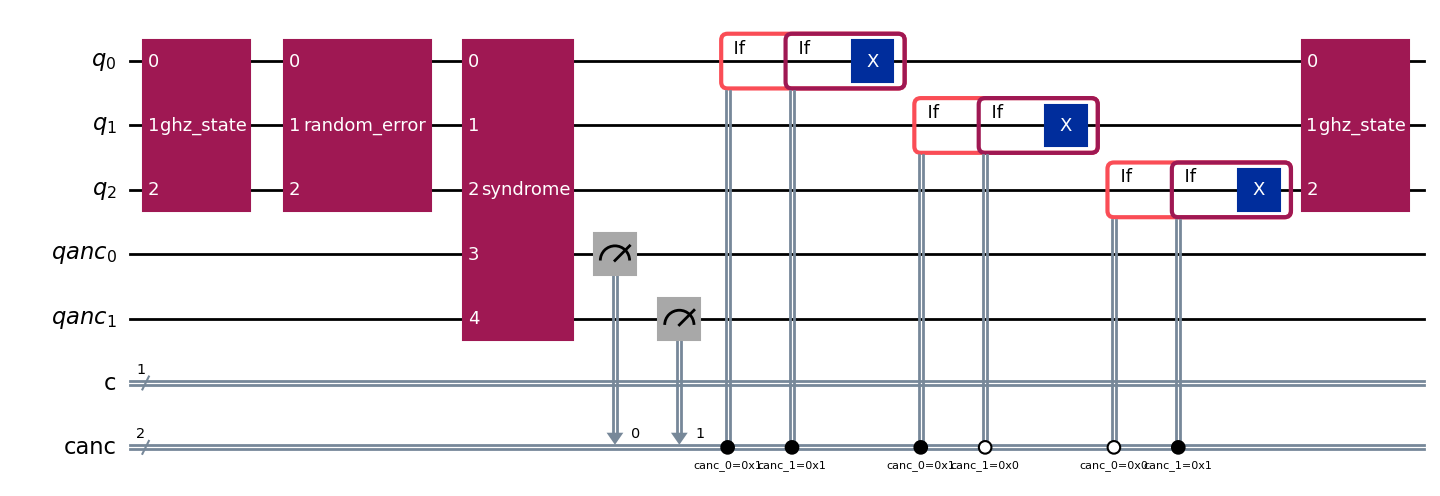

In [21]:
qc.draw(output="mpl", style="iqp", plot_barriers=False)

Transpilando el circuito podemos ver las puertas que hay detrás de esos bloques:

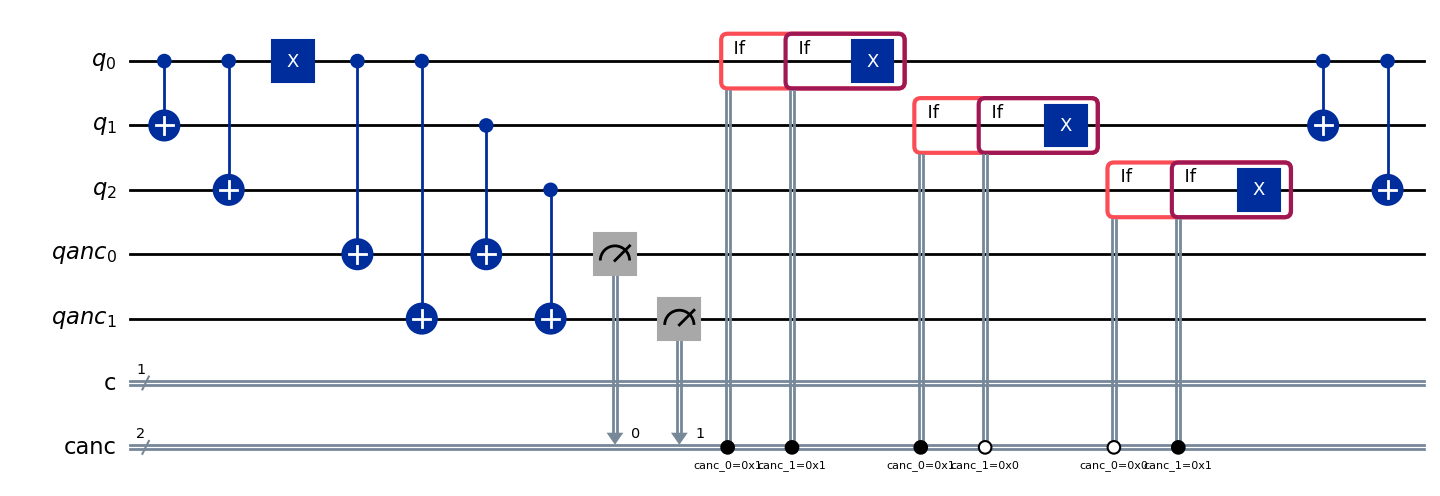

In [22]:
# Transpile the quantum circuit for the selected backend due to QFT
qct = transpile(circuits=qc, backend=backend)
qct.draw(output="mpl", style="iqp", plot_barriers=False)

### Resultados

Si ejecutamos el circuito, siguiendo la tabla de síndrome, vemos que los qubit ancilla detectan correctamente dónde está el error y se corrige mediante la correspondiente puerta X, dando como valor el final, el valor corregido.

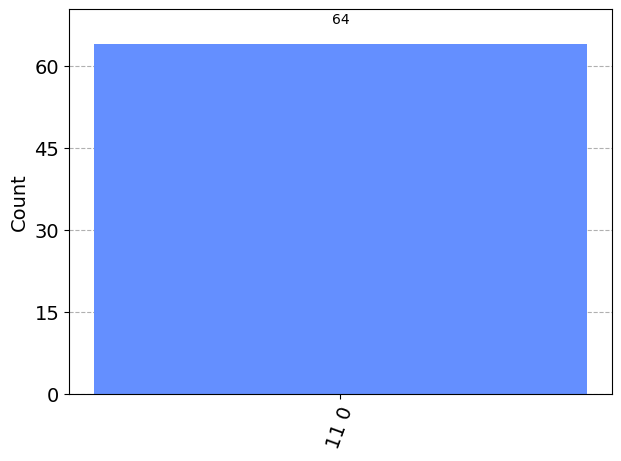

In [23]:
# Execute the quantum circuit and get the results
result = execute(qct, backend=backend, shots=64).result()

# We get the results and show them in the histogram
counts = result.get_counts(qct)
plot_histogram(counts)

A parte del resultado, podemos ver la evolución del vector de estado del circuito. Vamos a crear una función que transforme la información de la ejecución y la represente en Latex.

In [24]:
def statevector_evolution(result):
    """
    Convert statevectors from a quantum result into LaTeX representation.

    Parameters:
    - result (Result): Quantum result obtained from executing a quantum circuit.

    Returns:
    - sv_latex (list of str): List of statevectors in LaTeX representation.
    """
    # Retrieve statevectors from the results
    sv_dict = result.data(0)

    # Remove the first item from the dictionary, which contains the counts
    sv_dict.pop(next(iter(sv_dict)))

    # Sort the elements of the dictionary
    sv_dict = dict(sorted(sv_dict.items()))

    # Combine the statevectors and convert them to LaTeX
    sv_latex = join_sv_latex(sv_dict)

    return sv_latex

Dado nuestro resultado, transformamos los datos y vemos cuál ha sido la evolución. Los dos primeros qubits son los ancilla.

In [25]:
sv_evo = statevector_evolution(result)
display_latex(sv_evo)

<IPython.core.display.Math object>

Podemos ver que se ha producido un error, se ha detectado y finalmente corregido.

Añadimos todas las bloques en una sola función, para facilitar la ejecución.

In [26]:
def three_bit_code(error_type="flip", num_q=3, num_q_anc=2, num_error=1):
    """
    Implements a three-bit quantum error correction code.

    Parameters:
    - error_type (str): Type of error. Can be 'flip' or 'phase'. Defaults to 'flip'.

    Returns:
    - qc (QuantumCircuit): Quantum circuit implementing the three-bit quantum error correction code.
    """

    # Define quantum and classical registers
    qreg = QuantumRegister(num_q, "q")
    qreg_anc = QuantumRegister(num_q_anc, "qanc")
    creg = ClassicalRegister(num_q, "c")
    creg_anc = ClassicalRegister(num_q_anc, "canc")

    # Create the quantum circuit
    qc = QuantumCircuit(qreg, qreg_anc, creg, creg_anc)

    # Generate the error gate and GHZ state
    qc_error = random_error(num_q=num_q, error_type=error_type, num_error=num_error)
    qc_ghz = ghz_state(num_q)
    qc_syndrome = three_bit_syndrome()

    # Encodes the qubit in a three-qubit entangled state
    qc.append(qc_ghz, qargs=qreg[:num_q])

    # Apply Hadamard gates for phase error correction
    if error_type == "phase":
        qc.h(range(num_q))

    # Adds a random bit-flip error
    qc.append(qc_error, qargs=qreg[:num_q])

    # Apply Hadamard gates for phase error correction
    if error_type == "phase":
        qc.h(range(num_q))

    # Adds additional two qubits for error-correction
    qc.append(qc_syndrome, qargs=qc.qubits)

    # Measure the two additional qubits
    qc.measure(qreg_anc, creg_anc)

    # Do error correction based on the measurements
    double_if_test_x(qc, creg_anc[0], creg_anc[1], qreg[0], values=[1, 1])
    double_if_test_x(qc, creg_anc[0], creg_anc[1], qreg[1], values=[1, 0])
    double_if_test_x(qc, creg_anc[0], creg_anc[1], qreg[2], values=[0, 1])

    # Decodes the qubit from the three-qubit entangled state
    qc.append(qc_ghz, qargs=qreg[:num_q])

    return qc

# Error de fase de bits en el código de tres bits

El error de cambio de fase afecta a los estados de la base computacional de la siguiente manera:
$$
|0\rangle \rightarrow \sigma_z|0\rangle = |0\rangle, \quad |1\rangle \rightarrow \sigma_z|1\rangle = -|1\rangle.
$$
Así, un estado genérico $ |\psi\rangle = \alpha|0\rangle + \beta|1\rangle $ se mapea en $ \sigma_z|\psi\rangle = \alpha|0\rangle - \beta|1\rangle $.
El método anterior no puede corregir errores de fase. Sin embargo, observamos que un error de cambio de fase en la base computacional $ \{|0\rangle, |1\rangle\} $ se convierte en un error de cambio de bit en la base $ \{|+\rangle, |-\rangle\} $, donde
$$
|+\rangle = \sqrt{\frac{1}{2}}(|0\rangle + |1\rangle), \quad |-\rangle = \sqrt{\frac{1}{2}}(|0\rangle - |1\rangle).
$$
De hecho, tenemos $ \sigma_z|+\rangle = |-\rangle $ y $ \sigma_z|-\rangle = |+\rangle $. Podemos transformar los vectores de la base computacional en los nuevos vectores de base (y viceversa) mediante la compuerta Hadamard. Por lo tanto, para corregir errores de fase:
$$
|0\rangle \rightarrow |0L\rangle = |++\rangle, \quad |1\rangle \rightarrow |1L\rangle = |--\rangle,
$$
y corregimos los errores de cambio de bit en la base $ \{|+\rangle, |-\rangle\} $ usando el método descrito anteriormente.

Como hemos comentado antes, para poder corregir errores de fase, basta con añadir puertas Hadamart. Para ello, simplemente tenemos que llamar a la función anteriormente creada e indicarle que el error es de fase.

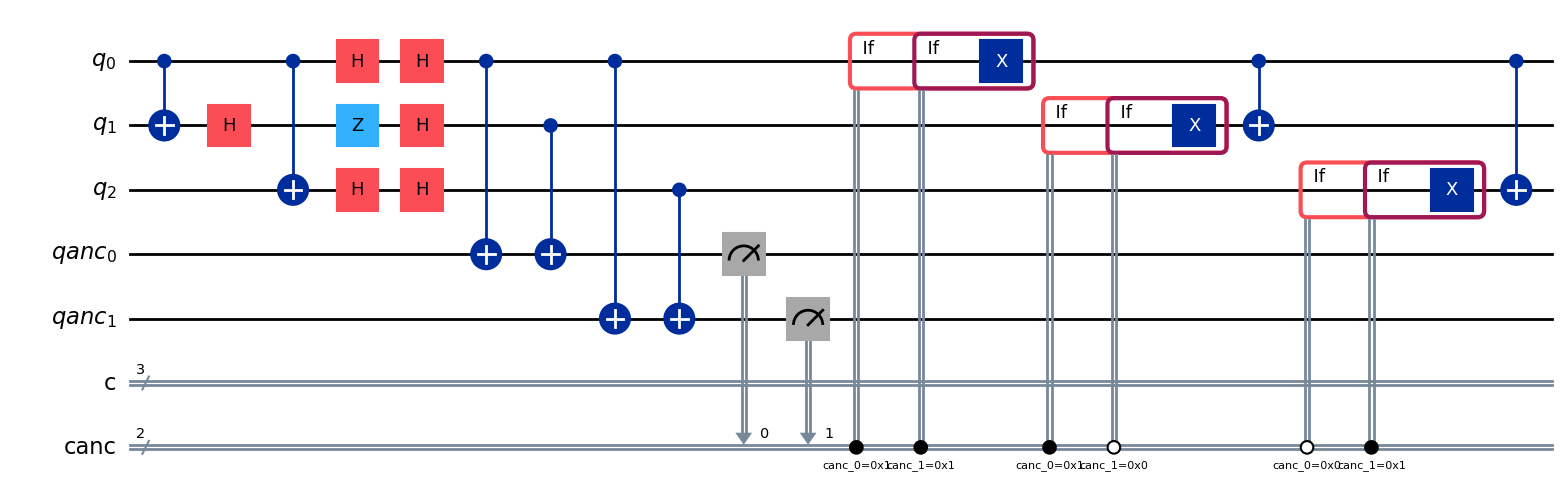

In [27]:
# We create the circuit to correct a phase error.
tbc = three_bit_code(error_type="phase")

# Run the quantum circuit on a aer_simulator simulator backend
backend = Aer.get_backend("aer_simulator")

# Transpile the quantum circuit for the selected backend due to QFT
qct = transpile(circuits=tbc, backend=backend)

# Draw the transpiled circuit.
qct.draw(output="mpl", style="iqp", plot_barriers=False)

Vemos que tenemos el mismo circuito que antes pero añadiendo las puertas Hadamart únicamente. Las puertas se pueden ver movidas porque no se han añadido barreras en el circuito.

### Resultados

Si ejecutamos, vemos que el error se detecta y corrige correctamente.

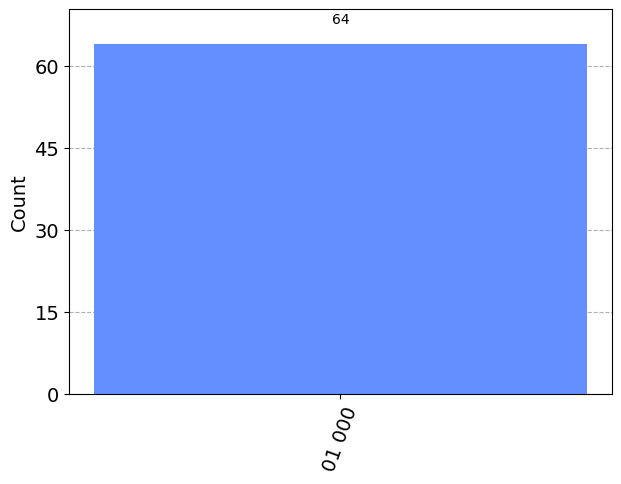

In [28]:
# Execute the quantum circuit and get the results
result = execute(qct, backend=backend, shots=64).result()
counts = result.get_counts(qct)
plot_histogram(counts)

# Algoritmo de Shor (9 qubits)

## Descripción del algoritmo

El código de Shor de nueve qubits emplea la siguiente codificación:
$$
|0\rangle \rightarrow |0L\rangle \equiv \sqrt{\frac{1}{8}}(|000\rangle + |111\rangle)
$$
$$
|1\rangle \rightarrow |1L\rangle \equiv \sqrt{\frac{1}{8}}(|000\rangle - |111\rangle)
$$
Así, un estado cuántico genérico $|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$ se mapea en $\alpha|0L\rangle + \beta|1L\rangle$. Los dos primeros CNOT y las compuertas de Hadamard de este circuito implementan la codificación de cambio de fase de tres qubits.
$$
|0\rangle \rightarrow |+++\rangle, \quad |1\rangle \rightarrow |---\rangle.
$$
Luego, las últimas compuertas CNOT codifican cada uno de estos tres qubits en un bloque de tres, mediante la codificación de cambio de bit de tres qubits del anterior algoritmo.
$$
|+\rangle = \sqrt{\frac{1}{2}}(|0\rangle + |1\rangle) \rightarrow \sqrt{\frac{1}{2}}(|000\rangle + |111\rangle)
$$
$$
|-\rangle = \sqrt{\frac{1}{2}}(|0\rangle - |1\rangle) \rightarrow \sqrt{\frac{1}{2}}(|000\rangle - |111\rangle)
$$

Este código puede corregir tanto errores de cambio de bit como errores de cambio de fase. En cada bloque de tres qubits, se puede detectar y corregir un solo error de cambio de bit siguiendo el método descrito en el anterior algoritmo. Además, podemos lidiar con errores de fase que afectan a un solo qubit. Supongamos que el error de fase ocurre en el primer qubit. Como consecuencia, el estado del primer bloque de qubits se modifica de la siguiente manera (descuidando la normalización de la función de onda):
$$
|000\rangle + |111\rangle \rightarrow |000\rangle - |111\rangle,
$$
$$
|000\rangle - |111\rangle \rightarrow |000\rangle + |111\rangle.
$$
Para detectar este error de cambio de fase sin perturbar el estado cuántico codificado $|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$, debemos realizar mediciones colectivas. Más precisamente, medimos
$$
y_0 = \sigma^{(1)}_x \sigma^{(2)}_x \sigma^{(3)}_x \sigma^{(4)}_x \sigma^{(5)}_x \sigma^{(6)}_x,
$$
$$
y_1 = \sigma^{(1)}_x \sigma^{(2)}_x \sigma^{(3)}_x \sigma^{(7)}_x \sigma^{(8)}_x \sigma^{(9)}_x.
$$
Tenemos
$$
\sigma^{(1)}_x \sigma^{(2)}_x \sigma^{(3)}_x (|000\rangle + |111\rangle) = |000\rangle + |111\rangle,
$$
$$
\sigma^{(1)}_x \sigma^{(2)}_x \sigma^{(3)}_x (|000\rangle - |111\rangle) = -(|000\rangle - |111\rangle).
$$
Por lo tanto, si el error de cambio de fase afecta al primer bloque de qubits, obtenemos $(y_0, y_1) = (-1, -1)$. Similarmente, los casos $(y_0, y_1) = (1, 1)$, $(1, -1)$ y $(-1, 1)$ corresponden a la ausencia de errores, error de fase en el tercer bloque y error de fase en el segundo bloque, respectivamente. Para corregir un error de fase que ocurre en el primer bloque de qubits, aplicamos el operador $\sigma^{(1)}_z \sigma^{(2)}_z \sigma^{(3)}_z$ ya que
$$
\sigma^{(1)}_z \sigma^{(2)}_z \sigma^{(3)}_z (|000\rangle \pm |111\rangle) = |000\rangle \mp |111\rangle.
$$


## Implementación

Este circuito se basa en el diseño presentado en Benenti, G., Casati, G., & Strini, G. (2004).

### Constantes y circuito cuántico

Vamos a definir las constantes para este algoritmo, indicando que sólo ocurre un error de amplitud y utilizaremos 9 qubits y 8 de ancilla.

In [29]:
num_qubits = 9
num_q_anc = 8

Como hemos hecho con el anterior algoritmo, creamos el circuito cuántico a partir de las constantes.

In [30]:
# Define quantum and classical registers
qreg = QuantumRegister(num_qubits, "q")
qreg_anc = QuantumRegister(num_q_anc, "qanc")
creg = ClassicalRegister(num_qubits, "c")
creg_anc = ClassicalRegister(num_q_anc, "canc")

# Create the quantum circuit
qc = QuantumCircuit(qreg, qreg_anc, creg, creg_anc)
qc.save_statevector("00. Initialize")

### Bloques funcionales

Este algoritmo utilizará los mismos bloques funcionales y funciones creadas en el anterior algoritmo.

### Creación del circuito

Creamos los circuitos de error, estado GHZ y cálculo del síndrome para posteriormente incluirlos en el circuito del algoritmo.

In [31]:
# Generate the error gate and GHZ state
qc_error_flip = random_error(num_q=3, error_type="flip", forced_error=0)
qc_error_phase = random_error(num_q=3, error_type="phase", forced_error=0)
qc_error_both = random_error(num_q=3, error_type="both", forced_error=0)
qc_ghz = ghz_state(3)
qc_syndrome = three_bit_syndrome()

Aplicamos dos CNOT a los primeros qubits de cada bloque para que todos tengan el mismo valor.

In [32]:
# Spread the first bit state to all blocks
qc.cx(control_qubit=qreg[0], target_qubit=qreg[3])
qc.cx(control_qubit=qreg[0], target_qubit=qreg[6])
qc.barrier()
qc.save_statevector("01. Spread the first bit state to all blocks")

Para cada bloque, añadimos una Hadamard en el primer bit y el estado GHZ.

In [33]:
# Encodes the qubit in a three-qubit entangled state
for i in range(0, 9, 3):
    qc.h(i)
    qc.append(qc_ghz, qargs=qreg[i : i + 3])
qc.barrier()
qc.save_statevector("02. Encodes the qubit in a three-qubit entangled state")

Añadimos un error de amplitud en cada bloque y un error de amplitud y de fase en el último bloque. Para facilitar el análisis del resultado, todos los errores ocurren en el primer qubit de cada bloque.

In [34]:
# Adds a random bit-flip error
qc.append(qc_error_flip, qargs=qreg[0:3])
qc.append(qc_error_flip, qargs=qreg[3:6])
qc.append(qc_error_both, qargs=qreg[6:9])
qc.barrier()
qc.save_statevector("03. Adds an error in each block")

Calculamos la posición del síndrome para cada bloque y añadimos el cálculo de síndrome.

In [35]:
# Adds syndrome detection to ancilla qubits
for i in range(0, 9, 3):
    anc_pos = int(num_qubits + 2 * i / 3)
    both_register = qc.qubits[i : i + 3] + qc.qubits[anc_pos : anc_pos + 2]
    qc.append(qc_syndrome, qargs=both_register)
    qc.barrier()
qc.save_statevector("04. Adds syndrome detection to ancilla qubits")

Medimos los qubit ancilla para calcular el síndrome del error de amplitud.

In [36]:
# Measure the two additional qubits
qc.measure(qreg_anc[:-2], creg_anc[:-2])
qc.barrier()
qc.save_statevector("05. Measure ancilla")

Siguiendo la misma tabla de síndrome que en el anterior algoritmo, aplicamos la misma lógica.

In [37]:
values = [[1, 1], [1, 0], [0, 1]]

for i in range(0, 9, 3):
    # Calculate index
    i_creg = int(2 * i / 3)

    # Amplitude correction
    double_if_test_x(
        qc, creg_anc[i_creg], creg_anc[i_creg + 1], qreg[i], values=values[0]
    )
    double_if_test_x(
        qc, creg_anc[i_creg], creg_anc[i_creg + 1], qreg[i + 1], values=values[1]
    )
    double_if_test_x(
        qc, creg_anc[i_creg], creg_anc[i_creg + 1], qreg[i + 2], values=values[2]
    )
    qc.barrier()
qc.save_statevector("06. Applying X gates")

Para el cálculo del error de fase, añadimos puertas Hadamard:

In [38]:
# Adding hadamart
for i in range(9):
    qc.h(i)
qc.barrier()
qc.save_statevector("07. Adding hadamart")

Añadimos múltiples CNOT, siguiendo la misma lógica que el anterior cálculo del síndrome, tratando a cada bloque como si fuera un qubit:

In [39]:
# Adding multiple controlled X gate
qc.append(XGate().control(6), qc.qubits[0:6] + [qc.qubits[-2]])
qc.append(XGate().control(6), qc.qubits[0:3] + qc.qubits[6:9] + [qc.qubits[-1]])
qc.save_statevector("08. Adding multiple controlled X gate")

Y finalmente volvemos a aplicar las puertas Hadamard.

In [40]:
# Adding hadamart
for i in range(9):
    qc.h(i)
qc.barrier()
qc.save_statevector("09. Adding hadamart")

Medimos los dos últimos bits ancilla para detectar el error de fase. 

In [41]:
# Measure the two additional qubits
qc.measure(qreg_anc[-2:], creg_anc[-2:])
qc.barrier()
qc.save_statevector("10. Measure ancilla")

De la misma manera, aplicamos las puertas Z al bloque entero donde haya el error con la misma tabla de valores de síndrome.

In [42]:
values = [[1, 1], [1, 0], [0, 1]]

# Do error correction based on the measurements
for i in range(0, 9, 3):
    # Calculate index
    i_z_block = int(i / 3)

    # Phase correction
    double_if_test_z(qc, creg_anc[-2], creg_anc[-1], qreg[i], values=values[i_z_block])
    double_if_test_z(
        qc, creg_anc[-2], creg_anc[-1], qreg[i + 1], values=values[i_z_block]
    )
    double_if_test_z(
        qc, creg_anc[-2], creg_anc[-1], qreg[i + 2], values=values[i_z_block]
    )
    qc.barrier()

qc.save_statevector("11. Do error correction based on the measurements")

El circuito sin transpilar quedaría así:

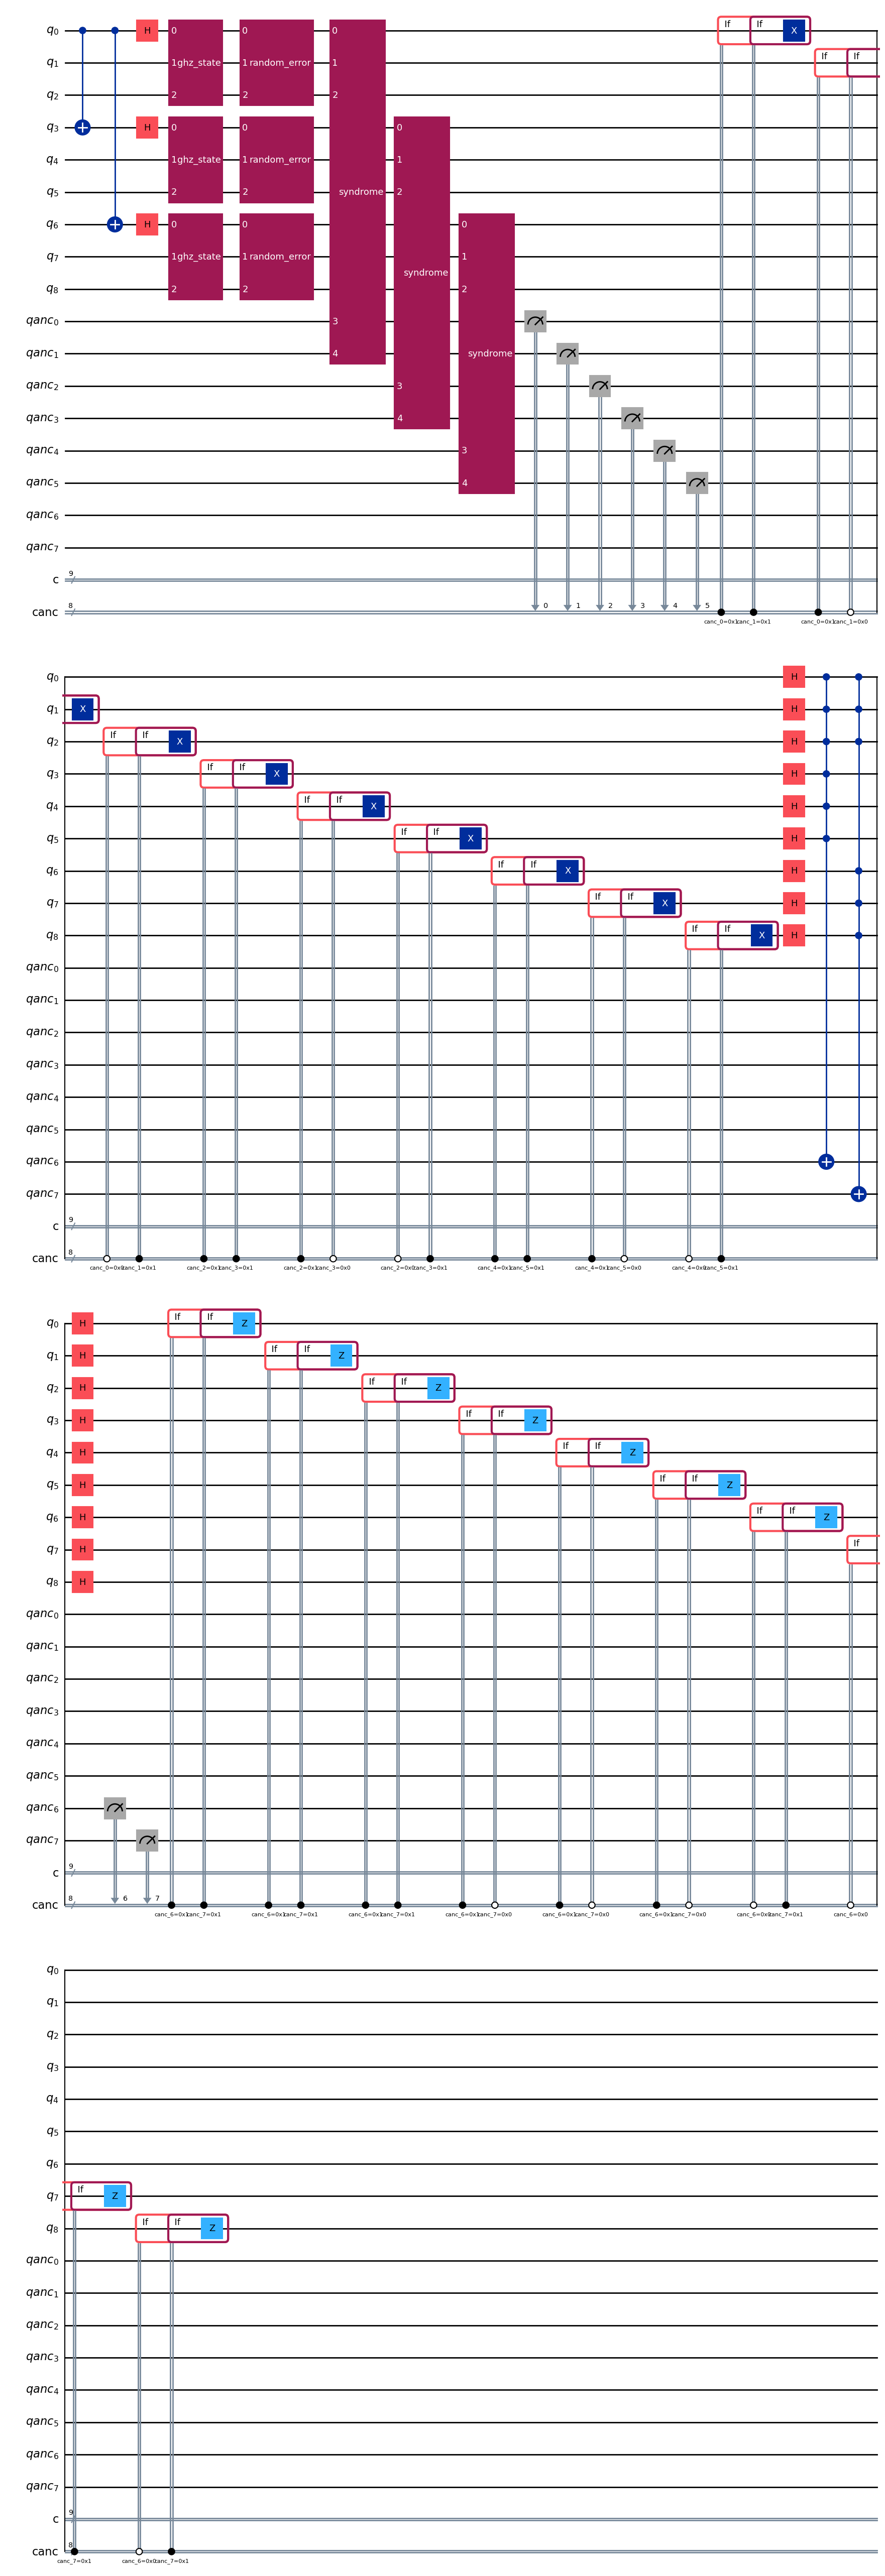

In [43]:
qc.draw(output="mpl", style="iqp", plot_barriers=False)

Transpilamos el circuito y vemos de qué puertas se compone:

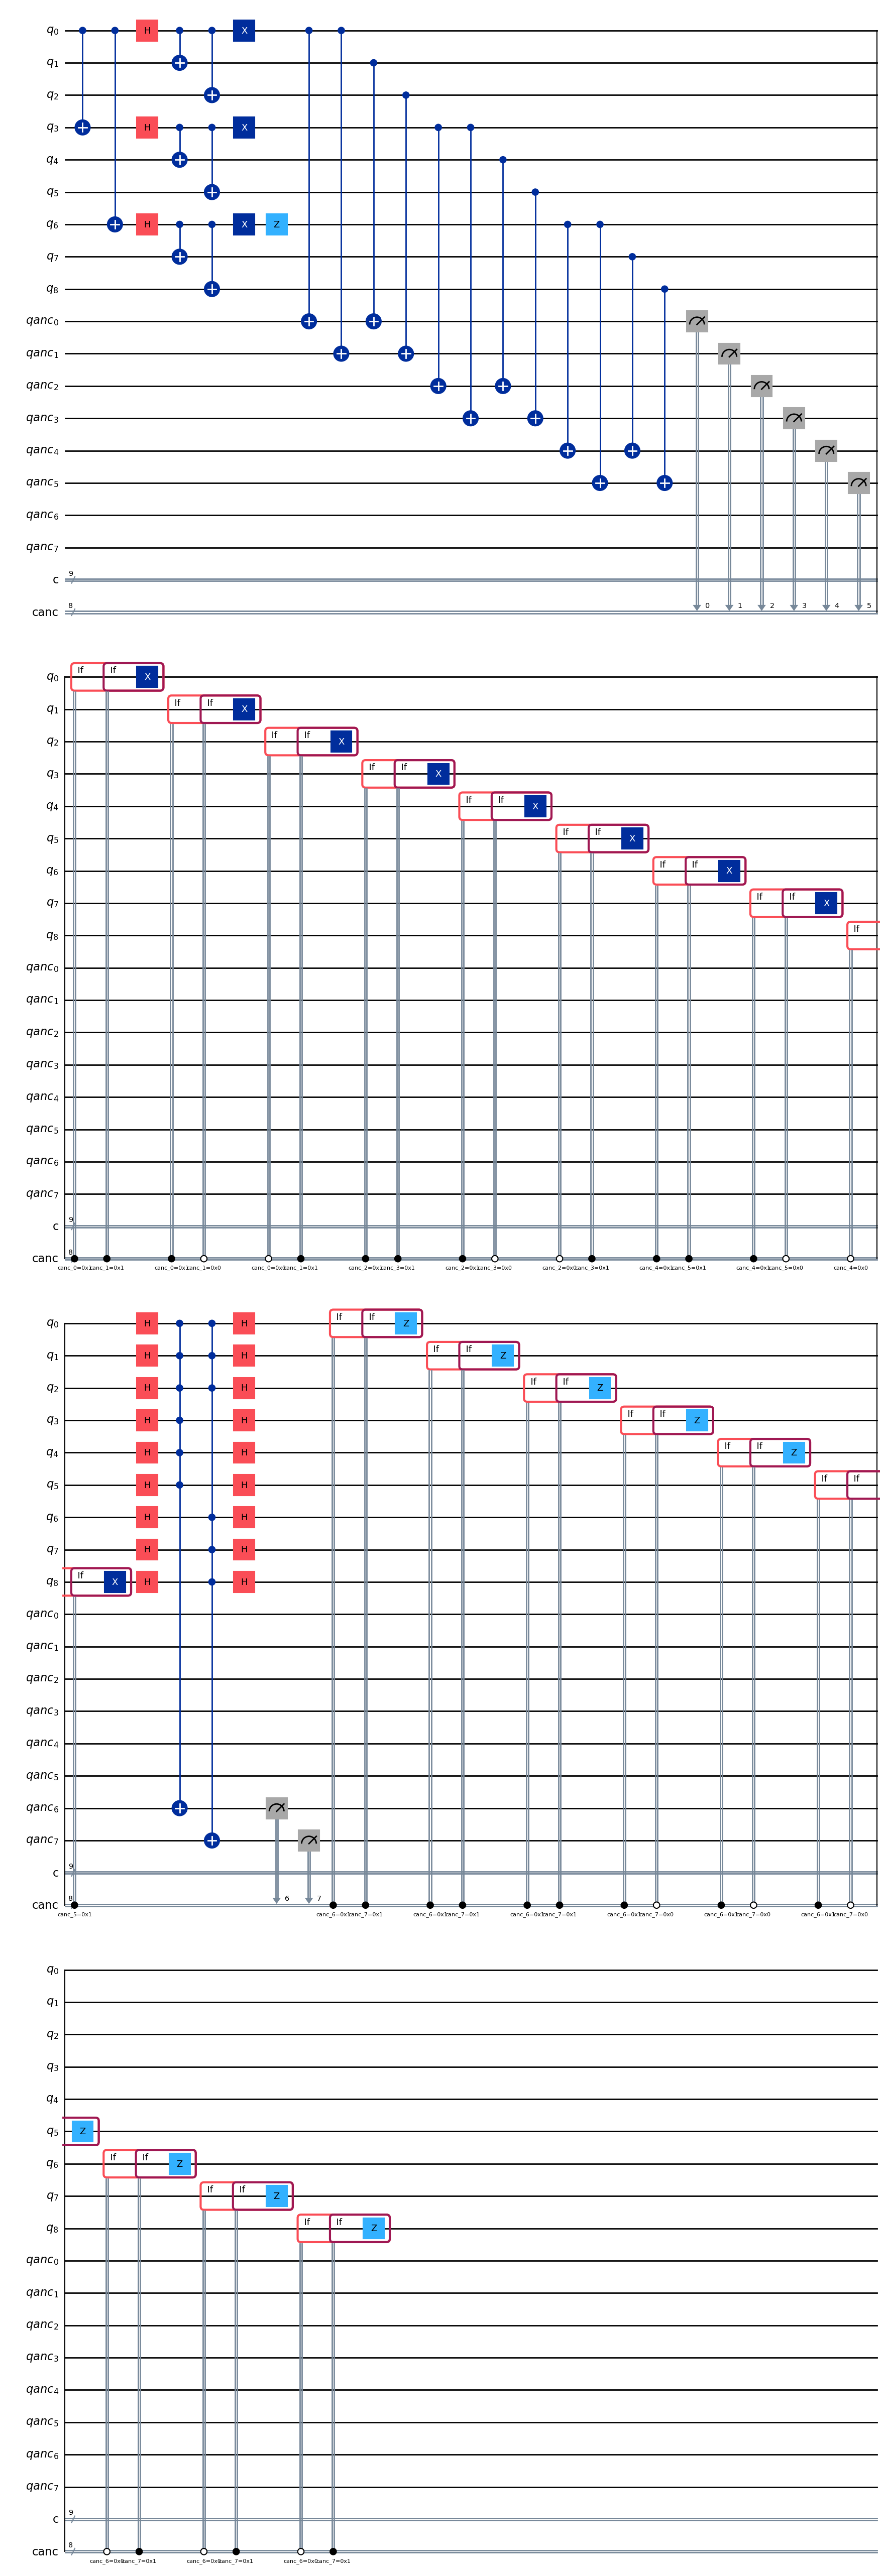

In [44]:
# Transpile the quantum circuit for the selected backend due to QFT
qct = transpile(circuits=qc, backend=backend)

#
qct.draw(output="mpl", style="iqp", plot_barriers=False)

### Resultados

Ejecutamos el circuito y vemos cómo se detectan los errores en cada bloque y se corrige.

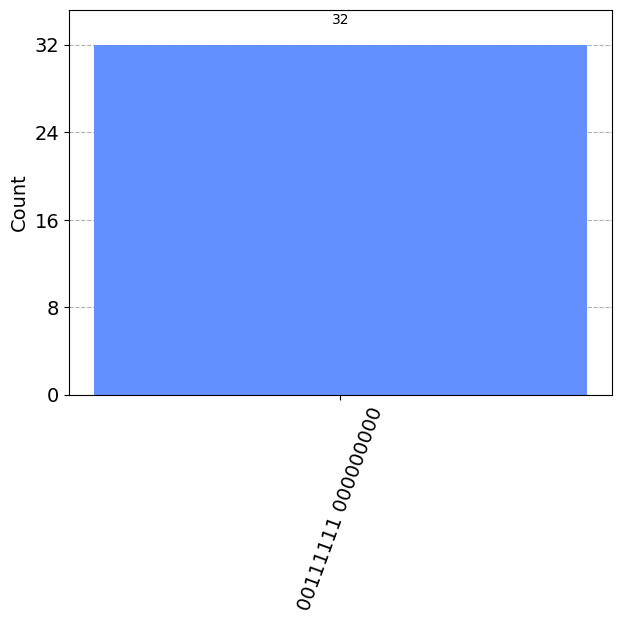

In [45]:
# Execute the quantum circuit and get the results
result = execute(qct, backend=backend, shots=32).result()
counts = result.get_counts(qct)
plot_histogram(counts)

Podemos ver la evolución del vector de estado tras cada operación:

In [46]:
sv_evo = statevector_evolution(result)
display_latex(sv_evo)

<IPython.core.display.Math object>

Si encapsulamos todo el código del algoritmo quedaría así:

In [47]:
def shor_code(num_q=9, num_q_anc=8, qc_error_1=None, qc_error_2=None, qc_error_3=None):
    """
    Implements a three-bit quantum error correction code based on Shor's code.

    Parameters:
    - num_q (int): Number of qubits used to encode the logical qubit and perform error correction.
    - num_q_anc (int): Number of additional ancillary qubits used in error correction.
    - qc_error_1 (QuantumCircuit or None): Quantum circuit representing the first error gate.
    - qc_error_2 (QuantumCircuit or None): Quantum circuit representing the second error gate.
    - qc_error_3 (QuantumCircuit or None): Quantum circuit representing the third error gate.

    Returns:
    - qc (QuantumCircuit): Quantum circuit implementing the three-bit quantum error correction code.
    """

    # Define quantum and classical registers
    qreg = QuantumRegister(num_q, "q")
    qreg_anc = QuantumRegister(num_q_anc, "qanc")
    creg = ClassicalRegister(num_q, "c")
    creg_anc = ClassicalRegister(num_q_anc, "canc")

    # Create the quantum circuit
    qc = QuantumCircuit(qreg, qreg_anc, creg, creg_anc)

    # Generate the error gate and GHZ state
    qc_error_1 = random_error(num_q=3, error_type="flip", forced_error=0) or qc_error_1
    qc_error_2 = random_error(num_q=3, error_type="flip", forced_error=0) or qc_error_2
    qc_error_3 = random_error(num_q=3, error_type="both", forced_error=0) or qc_error_3
    qc_ghz = ghz_state(3)
    qc_syndrome = three_bit_syndrome()

    # Spread the first bit state to all blocks
    qc.cx(control_qubit=qreg[0], target_qubit=qreg[3])
    qc.cx(control_qubit=qreg[0], target_qubit=qreg[6])

    # Encodes the qubit in a three-qubit entangled state
    for i in range(0, 9, 3):
        qc.h(i)
        qc.append(qc_ghz, qargs=qreg[i : i + 3])

    # Adds a random bit-flip error
    qc.append(qc_error_1, qargs=qreg[0:3])
    qc.append(qc_error_2, qargs=qreg[3:6])
    qc.append(qc_error_3, qargs=qreg[6:9])

    # Adds additional two qubits for error-correction
    for i in range(0, 9, 3):
        anc_pos = int(num_q + 2 * i / 3)
        both_register = qc.qubits[i : i + 3] + qc.qubits[anc_pos : anc_pos + 2]
        qc.append(qc_syndrome, qargs=both_register)

    # Adding Hadamard gates
    for i in range(9):
        qc.h(i)

    # Adding multiple controlled X gates
    qc.append(XGate().control(6), qc.qubits[0:6] + [qc.qubits[-2]])
    qc.append(XGate().control(6), qc.qubits[0:3] + qc.qubits[6:9] + [qc.qubits[-1]])

    # Adding Hadamard gates
    for i in range(9):
        qc.h(i)

    # Measure ancillary qubits
    qc.measure(qreg_anc, creg_anc)

    # Do error correction based on the measurements
    values = [[1, 1], [1, 0], [0, 1]]
    for i in range(0, 9, 3):
        # Calculate index
        i_creg = int(2 * i / 3)
        i_z_block = int(i / 3)

        # Amplitude correction
        double_if_test_x(
            qc, creg_anc[i_creg], creg_anc[i_creg + 1], qreg[i], values=values[0]
        )
        double_if_test_x(
            qc, creg_anc[i_creg], creg_anc[i_creg + 1], qreg[i + 1], values=values[1]
        )
        double_if_test_x(
            qc, creg_anc[i_creg], creg_anc[i_creg + 1], qreg[i + 2], values=values[2]
        )

        # Phase correction
        double_if_test_z(
            qc, creg_anc[-2], creg_anc[-1], qreg[i], values=values[i_z_block]
        )
        double_if_test_z(
            qc, creg_anc[-2], creg_anc[-1], qreg[i + 1], values=values[i_z_block]
        )
        double_if_test_z(
            qc, creg_anc[-2], creg_anc[-1], qreg[i + 2], values=values[i_z_block]
        )

    return qc

# Algoritmo de Steane (7 qubits)



## Descripción del algoritmo

El código Steane es un código cuántico de corrección de errores introducido por Steane que codifica un qubit lógico en siete físicos y tiene distancia 3, lo que significa que puede corregir errores arbitrarios de hasta 1 qubit. Debido a estas características, decimos que es un código [[7, 1, 3]].


Además, el código Steane es un código estabilizador, es decir, suespacio de código puede ser generado por un subgrupo del grupo de Pauli, al que llamamos estabilizador. Todos los seis generadores del código Steane, que consisten en productos tensoriales de las puertas Pauli 𝑋 y 𝑍 y la puerta Identidad (𝐼) son: 

| Nombre | Operador                                     |
|------|-----------------------------------------------|
| 𝑔1   | 𝐼 ⊗ 𝐼 ⊗ 𝐼 ⊗ 𝑋 ⊗ 𝑋 ⊗ 𝑋 ⊗ 𝑋                     |
| 𝑔2   | 𝐼 ⊗ 𝑋 ⊗ 𝑋 ⊗ 𝐼 ⊗ 𝐼 ⊗ 𝑋 ⊗ 𝑋                     |
| 𝑔3   | 𝑋 ⊗ 𝐼 ⊗ 𝑋 ⊗ 𝐼 ⊗ 𝑋 ⊗ 𝐼 ⊗ 𝑋                     |
| 𝑔4   | 𝐼 ⊗ 𝐼 ⊗ 𝐼 ⊗ 𝑍 ⊗ 𝑍 ⊗ 𝑍 ⊗ 𝑍                     |
| 𝑔5   | 𝐼 ⊗ 𝑍 ⊗ 𝑍 ⊗ 𝐼 ⊗ 𝐼 ⊗ 𝑍 ⊗ 𝑍                     |
| 𝑔6   | 𝑍 ⊗ 𝐼 ⊗ 𝑍 ⊗ 𝐼 ⊗ 𝑍 ⊗ 𝐼 ⊗ 𝑍                     |



## Implementación

Este circuito se basa en el diseño presentado en Marinescu, D. C. y Marinescu, G. M. (2012) [2].

### Constantes y circuito cuántico

Vamos a definir las constantes para este algoritmo, indicando que sólo ocurre un error de amplitud y de fase en el primer qubit. Utilizaremos 7 qubits y 6 de ancilla.

In [48]:
num_qubits = 7
num_qubits_ancilla = 6

### Bloques funcionales

Este algoritmo utilizará los mismos bloques funcionales y funciones creadas en el anterior algoritmo. Debido a que no es práctico encapsular bloques en funciones, se implementará todo directamente.

### Creación del circuito


Como hemos hecho en los anteriores algoritmos, creamos el circuito con los qubits y qubits ancilla.

In [49]:
# Define quantum and classical registers
qreg = QuantumRegister(num_qubits, "q")
qreg_anc = QuantumRegister(num_qubits_ancilla, "qanc")
creg = ClassicalRegister(num_qubits, "c")
creg_anc = ClassicalRegister(num_qubits_ancilla, "canc")

# Create the quantum circuit
qc = QuantumCircuit(qreg, qreg_anc, creg, creg_anc)
qc.barrier()
qc.save_statevector("000. Initial state")

Añadimos un error de amplitud y de fase en el primer qubit para facilitar el análisis del resultado.

In [50]:
# Generate the error gate
qc_error = random_error(num_q=7, error_type="both", forced_error=0)

# Adds a random bit-flip error
qc.append(qc_error, qargs=qreg)

qc.barrier()
qc.save_statevector("010. Add phase and amplitude errors")

Siguiendo los [comentarios de este hilo](https://quantumcomputing.stackexchange.com/questions/28807/how-to-implement-the-circuit-of-steanes-code-for-quantum-error-correction), aplicamos las puertas CNOT siguiendo la tabla de códigos generadores. Esto permitirá detectar los errores de amplitud.

In [51]:
values = [[0, 2, 4, 6], [1, 2, 5, 6], [3, 4, 5, 6]]

for i, value in enumerate(values):
    for j in value:
        qc.cx(control_qubit=qreg[j], target_qubit=qreg_anc[i])

qc.barrier()
qc.save_statevector("020. Apply bit-flip error detection")

Aplicamos la puerta Hadamard a los tres últimos qubit ancilla para poder detectar errores de fase.

In [52]:
for i in range(3):
    qc.h(qc.num_qubits - i - 1)

qc.barrier()
qc.save_statevector("030. Add Hadamard")

Aplicamos las puertas CNOT.

In [53]:
qc.append(
    XGate().control(4),
    [qc.qubits[0]] + [qc.qubits[2]] + [qc.qubits[4]] + [qc.qubits[6]] + [qc.qubits[-3]],
)
qc.append(XGate().control(4), qc.qubits[1:3] + qc.qubits[5:7] + [qc.qubits[-2]])
qc.append(XGate().control(4), qc.qubits[3:7] + [qc.qubits[-1]])

qc.barrier()
qc.save_statevector("040. Apply CNOT in phase-flip error detection")

Y volvemos a aplicar las puertas Hadamard.

In [54]:
for i in range(3):
    qc.h(qc.num_qubits - i - 1)

qc.barrier()
qc.save_statevector("050. Add Hadamard")

Finalmente medimos el estado de los qubit ancilla.

In [55]:
# Measure ancillary qubits
qc.measure(qreg_anc, creg_anc)
qc.barrier()
qc.save_statevector("060. Measure")

Incluyendo los errores, el circuito quedaría así:

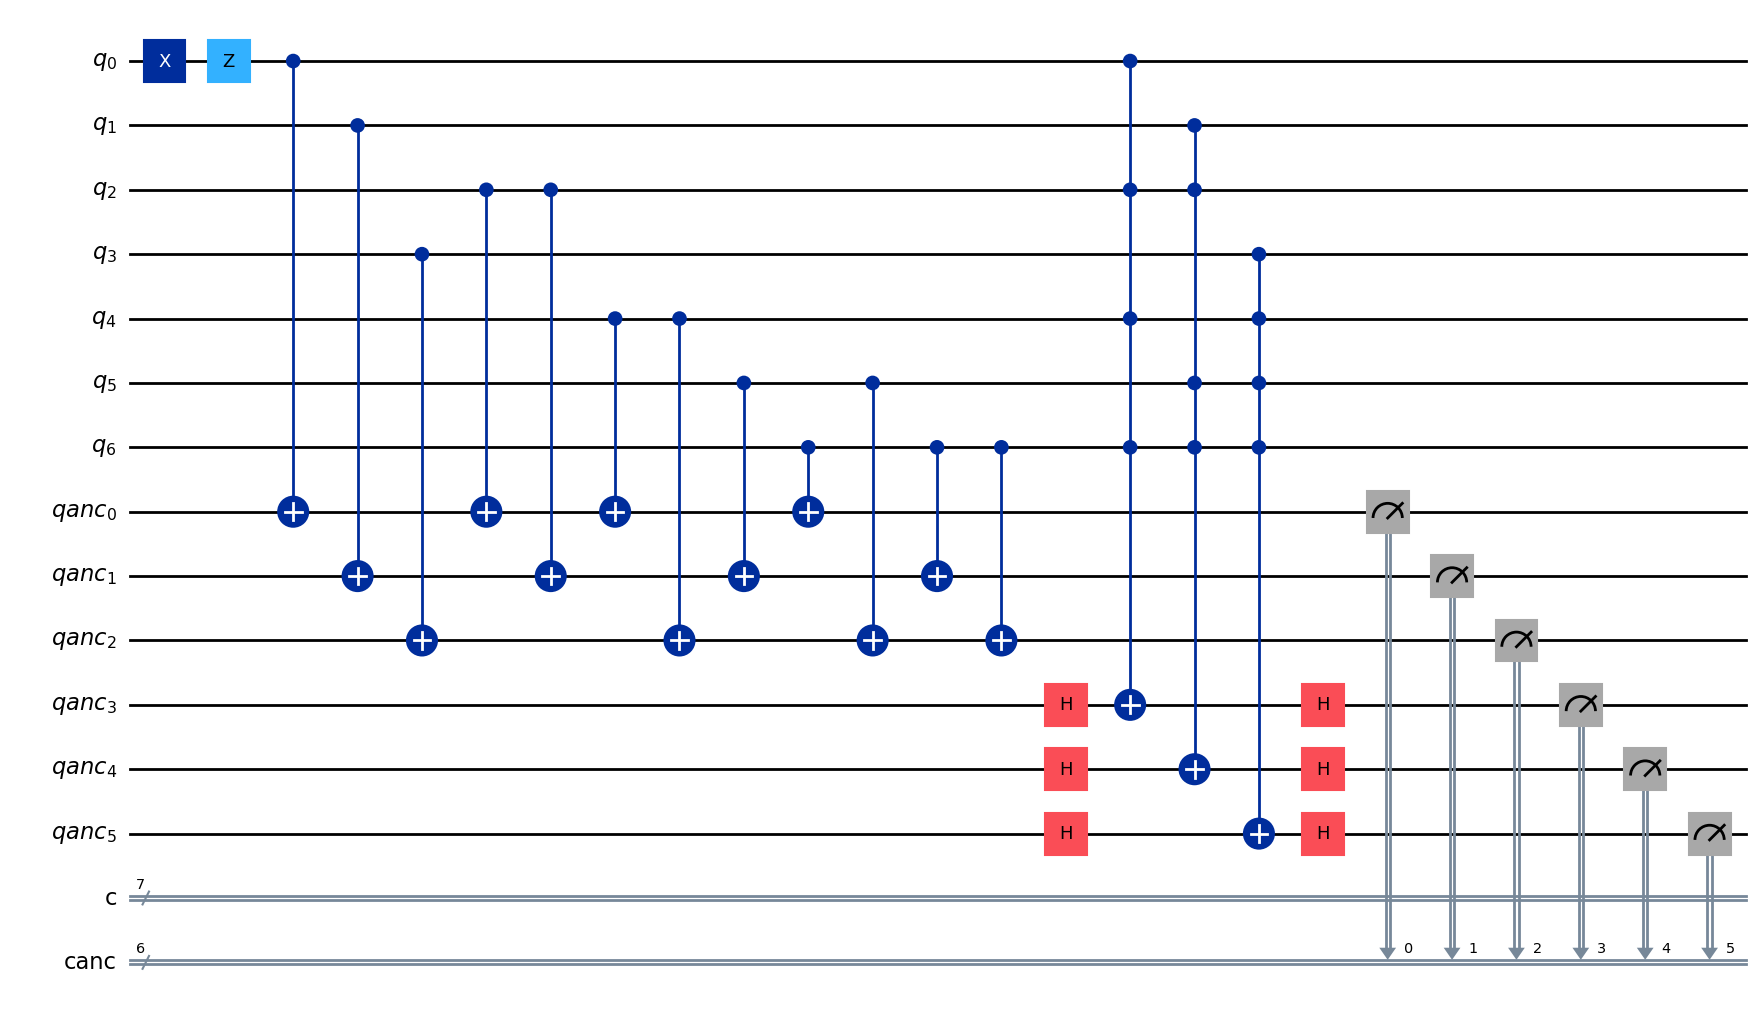

In [56]:
# Transpile the quantum circuit for the selected backend due to QFT
qct = transpile(circuits=qc, backend=backend)

# Show the circuit
qct.draw(output="mpl", style="iqp", plot_barriers=False)

### Resultados

Si ejecutamos, vemos que el error se detecta y corrige correctamente para el primer bit, donde hay error de amplitud y de fase.

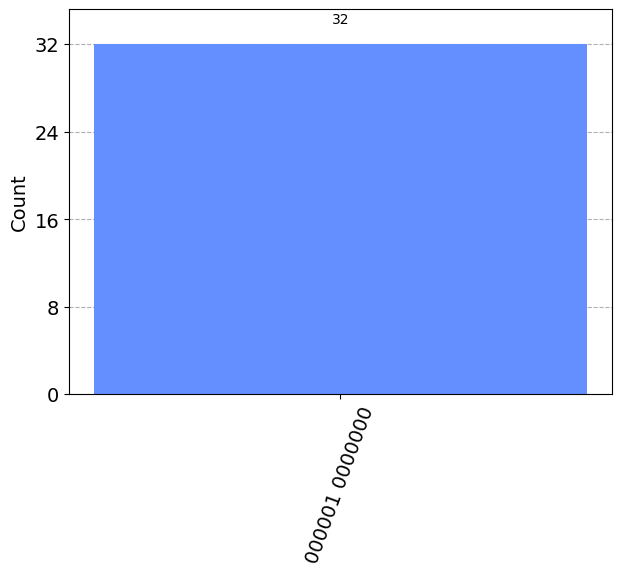

In [57]:
# Execute the quantum circuit and get the results
result = execute(qct, backend=backend, shots=32).result()
counts = result.get_counts(qct)
plot_histogram(counts)

El evolutivo del vector de estado es el siguiente:

In [58]:
sv_evo = statevector_evolution(result)
display_latex(sv_evo)

<IPython.core.display.Math object>

# Algoritmo de LaFlamme (5 qubits)



## Descripción del algoritmo

En este algoritmo, no vamos a necesitar qubits ancilla. El proceso es el siguiente:

- Codificamos el estado original distribuyendo la información cuántica entre cinco qubits, el número mínimo necesario para esta tarea. 

- Tenemos un circuito que lleva el estado inicial con cuatro qubits extra en el estado |0> al estado codificado. 

- El circuito se puede convertir en uno de descodificación simplemente ejecutándolo hacia atrás. Se trata de un circuito simétrico. 

- Leyendo los cuatro qubits extra a la salida del decodificador aprendemos cuál de las dieciséis alternativas, según la siguiente tabla, ha ocurrido. 

- El estado original del qubit codificado puede entonces restaurarse mediante una simple transformación unitaria.

La tabla de codificación es la siguiente:

| Error | abcd | $\rho \rangle$ |
|------------|--------|--------|
| Sin error | 0000 | $\alpha\|0\rangle + \beta\|1\rangle$ |
| $\sigma_x (3), \sigma_z (3)$ | 1101 | $-\alpha\|1\rangle + \beta\|0\rangle$ |
| $\sigma_x (5), \sigma_z (5)$ | 1111 | $-\alpha\|0\rangle + \beta\|1\rangle$ |
| $\sigma_x (2)$ | 0001 | $\alpha\|0\rangle - \beta\|1\rangle$ |
| $\sigma_z (3)$ | 1010 | $\alpha\|0\rangle - \beta\|1\rangle$ |
| $\sigma_z (5)$ | 1100 | $\alpha\|0\rangle - \beta\|1\rangle$ |
| $\sigma_x (2), \sigma_z (2)$ | 0101 | $\alpha\|0\rangle - \beta\|1\rangle$ |
| $\sigma_x (5)$ | 0011 | $-\alpha\|0\rangle - \beta\|1\rangle$ |
| $\sigma_z (1)$ | 1000 | $-\alpha\|0\rangle - \beta\|1\rangle$ |
| $\sigma_z (2)$ | 0100 | $-\alpha\|0\rangle - \beta\|1\rangle$ |
| $\sigma_z (4)$ | 0010 | $-\alpha\|0\rangle - \beta\|1\rangle$ |
| $\sigma_x (1)$ | 0110 | $-\alpha\|1\rangle + \beta\|0\rangle$ |
| $\sigma_x (3)$ | 0111 | $-\alpha\|1\rangle + \beta\|0\rangle$ |
| $\sigma_x (4)$ | 1011 | $-\alpha\|1\rangle + \beta\|0\rangle$ |
| $\sigma_x (1), \sigma_z (1)$ | 1110 | $-\alpha\|1\rangle + \beta\|0\rangle$ |
| $\sigma_x (4), \sigma_z (4)$ | 1001 | $-\alpha\|1\rangle + \beta\|0\rangle$ |


## Implementación

Este circuito se basa en el diseño presentado en Laflamme, R., Miquel, C., Paz, J. P., & Zurek, W. H. (1996) y Knill, E., Laflamme, R., & Viola, L. (2000).

### Constantes y circuito cuántico

Vamos a definir las constantes para este algoritmo, indicando que sólo ocurre un error de amplitud y de fase en el primer qubit. Utilizaremos 5 qubits y ningún qubit ancilla.

In [59]:
num_qubits = 5

### Bloques funcionales

Este algoritmo utilizará los mismos bloques funcionales y funciones creadas en el anterior algoritmo. Debido a que no es práctico encapsular bloques en funciones, se implementará todo directamente.

### Creación del circuito

Creamos el circuito de 5 qubits sin ancilla.

In [60]:
# Define quantum and classical registers
qreg = QuantumRegister(num_qubits, "q")
creg = ClassicalRegister(num_qubits, "c")

# Create the quantum circuit
qc = QuantumCircuit(qreg, creg)
qc.barrier()
qc.save_statevector("000. Initial state")

Aplicamos las puertas Hadamard

In [61]:
# Add Hadamard
for i in range(1, 4):
    qc.h(i)

qc.barrier()
qc.save_statevector("010. Add Hadamard")

Añadimos la colección de puertas que forman la primera parte del circuito simétrico:

In [62]:
# Add symetric codification circuit
qc.append(RZGate(math.pi).control(num_ctrl_qubits=3), [qc.qubits[0]] + qc.qubits[2:5])
qc.append(
    RZGate(math.pi).control(num_ctrl_qubits=3, ctrl_state="001"),
    [qc.qubits[0]] + qc.qubits[2:5],
)
qc.cx(control_qubit=qreg[0], target_qubit=qreg[4])
qc.cx(control_qubit=qreg[1], target_qubit=qreg[0])
qc.cx(control_qubit=qreg[1], target_qubit=qreg[4])
qc.cx(control_qubit=qreg[3], target_qubit=qreg[0])
qc.cx(control_qubit=qreg[2], target_qubit=qreg[4])
qc.append(RZGate(math.pi).control(2), qc.qubits[3:5] + [qc.qubits[0]])

qc.barrier()
qc.save_statevector("020. Add symetric codification circuit")

Añadimos un error de amplitud y de fase en el primer qubit.

In [63]:
# Generate the error gate and GHZ state
qc_error = random_error(num_q=5, error_type="both", forced_error=0)

# Adds a random bit-flip error
qc.append(qc_error, qargs=qreg)

qc.barrier()
qc.save_statevector("030. Add error")

Y añadimos la segunda parte del circuito simétrico, al revés de la primera parte.

In [64]:
# Add symetric codification circuit backwards
qc.append(RZGate(math.pi).control(2), qc.qubits[3:5] + [qc.qubits[0]])
qc.cx(control_qubit=qreg[2], target_qubit=qreg[4])
qc.cx(control_qubit=qreg[3], target_qubit=qreg[0])
qc.cx(control_qubit=qreg[1], target_qubit=qreg[4])
qc.cx(control_qubit=qreg[1], target_qubit=qreg[0])
qc.cx(control_qubit=qreg[0], target_qubit=qreg[4])
qc.append(
    RZGate(math.pi).control(num_ctrl_qubits=3, ctrl_state="001"),
    [qc.qubits[0]] + qc.qubits[2:5],
)
qc.append(RZGate(math.pi).control(num_ctrl_qubits=3), [qc.qubits[0]] + qc.qubits[2:5])

qc.barrier()
qc.save_statevector("040. Add symetric codification circuit backwards")

Aplicamos las puertas Hadamard

In [65]:
# Add Hadamard
for i in range(1, 4):
    qc.h(i)

qc.barrier()
qc.save_statevector("050. Add Hadamard")

Simplificamos la comprobación de valores implementando estas dos funciones, que son una extensión de la función creada en otros algoritmos. Para aplicar una X:

In [66]:
def quad_if_test_x(qc, reg_test, reg_gate, values=[0, 1, 2, 3]):
    """
    Apply an X gate to a register conditioned on the values of multiple test registers.

    Parameters:
    - qc (QuantumCircuit): The quantum circuit to which the gate is applied.
    - reg_test (list of QuantumRegister): The list of test registers.
    - reg_gate (QuantumRegister): The register to which the X gate is applied.
    - values (list of int): The values on which the test registers are conditioned.
                             Defaults to [0, 1, 2, 3].

    Returns:
    None
    """
    # Apply the X gate conditioned on the values of the test registers
    with qc.if_test((reg_test[0], values[0])):
        with qc.if_test((reg_test[1], values[1])):
            with qc.if_test((reg_test[2], values[2])):
                with qc.if_test((reg_test[3], values[3])):
                    qc.x(reg_gate)

Y para aplicar una Z:

In [67]:
def quad_if_test_z(qc, reg_test, reg_gate, values=[0, 1, 2, 3]):
    """
    Apply a Z gate to a register conditioned on the values of multiple test registers.

    Parameters:
    - qc (QuantumCircuit): The quantum circuit to which the gate is applied.
    - reg_test (list of QuantumRegister): The list of test registers.
    - reg_gate (QuantumRegister): The register to which the Z gate is applied.
    - values (list of int): The values on which the test registers are conditioned.
                             Defaults to [0, 1, 2, 3].

    Returns:
    None
    """
    # Apply the Z gate conditioned on the values of the test registers
    with qc.if_test((reg_test[0], values[0])):
        with qc.if_test((reg_test[1], values[1])):
            with qc.if_test((reg_test[2], values[2])):
                with qc.if_test((reg_test[3], values[3])):
                    qc.z(reg_gate)

Y para X y Z:

In [68]:
def quad_if_test_x_z(qc, reg_test, reg_gate, values=[0, 1, 2, 3]):
    """
    Apply an X and Z gate to a register conditioned on the values of multiple test registers.

    Parameters:
    - qc (QuantumCircuit): The quantum circuit to which the gate is applied.
    - reg_test (list of QuantumRegister): The list of test registers.
    - reg_gate (QuantumRegister): The register to which the gates are applied.
    - values (list of int): The values on which the test registers are conditioned.
                             Defaults to [0, 1, 2, 3].

    Returns:
    None
    """
    # Apply the X and Z gates conditioned on the values of the test registers
    with qc.if_test((reg_test[0], values[0])):
        with qc.if_test((reg_test[1], values[1])):
            with qc.if_test((reg_test[2], values[2])):
                with qc.if_test((reg_test[3], values[3])):
                    qc.x(reg_gate)
                    qc.z(reg_gate)

Realizamos las correcciones siguiendo la tabla de valores:

In [69]:
# Apply all error corrections based on the table
quad_if_test_x(qc, creg[1:], qreg[1], values=[0, 0, 0, 1])
quad_if_test_z(qc, creg[1:], qreg[3], values=[0, 0, 1, 0])
quad_if_test_x(qc, creg[1:], qreg[4], values=[0, 0, 1, 1])

quad_if_test_z(qc, creg[1:], qreg[1], values=[0, 1, 0, 0])
quad_if_test_x_z(qc, creg[1:], qreg[1], values=[0, 1, 0, 1])
quad_if_test_x(qc, creg[1:], qreg[0], values=[0, 1, 1, 0])
quad_if_test_x(qc, creg[1:], qreg[2], values=[0, 1, 1, 1])

quad_if_test_z(qc, creg[1:], qreg[0], values=[1, 0, 0, 0])
quad_if_test_x_z(qc, creg[1:], qreg[3], values=[1, 0, 0, 1])
quad_if_test_z(qc, creg[1:], qreg[2], values=[1, 0, 1, 0])
quad_if_test_x(qc, creg[1:], qreg[3], values=[1, 0, 1, 1])

quad_if_test_z(qc, creg[1:], qreg[4], values=[1, 1, 0, 0])
quad_if_test_x_z(qc, creg[1:], qreg[2], values=[1, 1, 0, 1])
quad_if_test_x_z(qc, creg[1:], qreg[0], values=[1, 1, 1, 0])
quad_if_test_x_z(qc, creg[1:], qreg[4], values=[1, 1, 1, 1])

qc.barrier()
qc.save_statevector("060. Apply corrections")

El circuito sin transpilar quedaría de la siguiente manera:

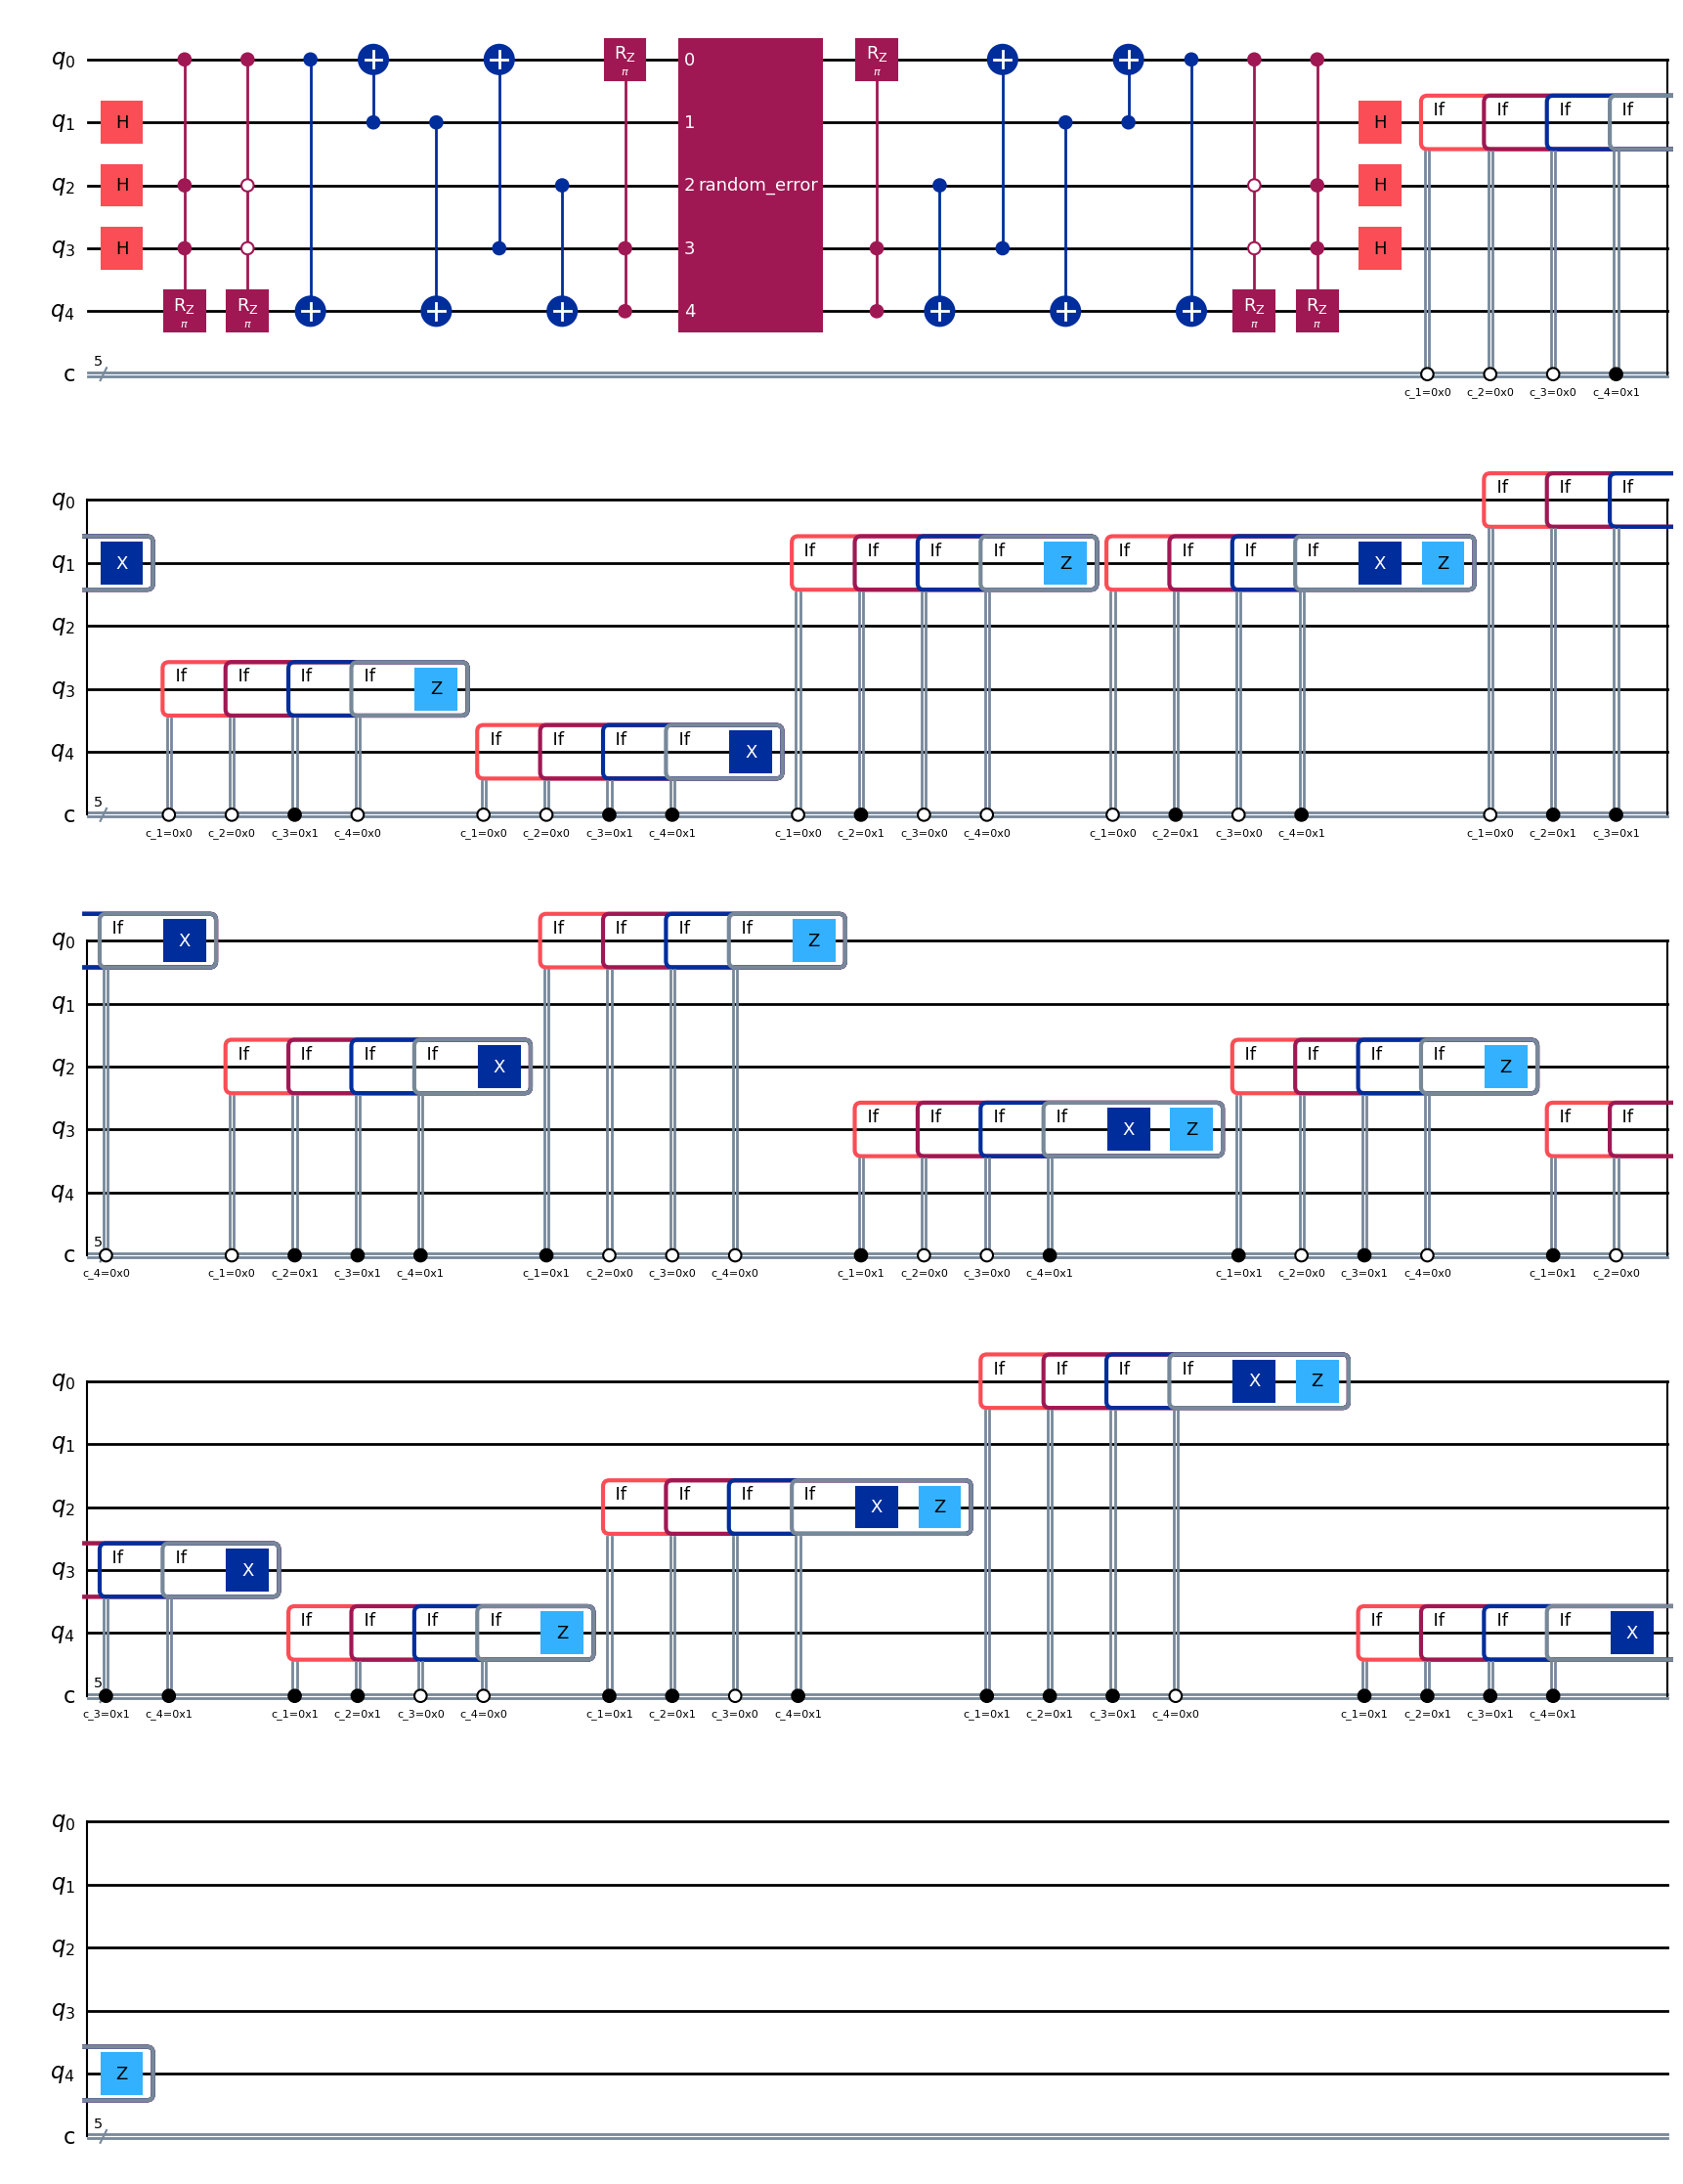

In [70]:
qc.draw(output="mpl", style="iqp", plot_barriers=False)

Transpilando, vemos cómo nos cambia el circuito a puertas unitarias.

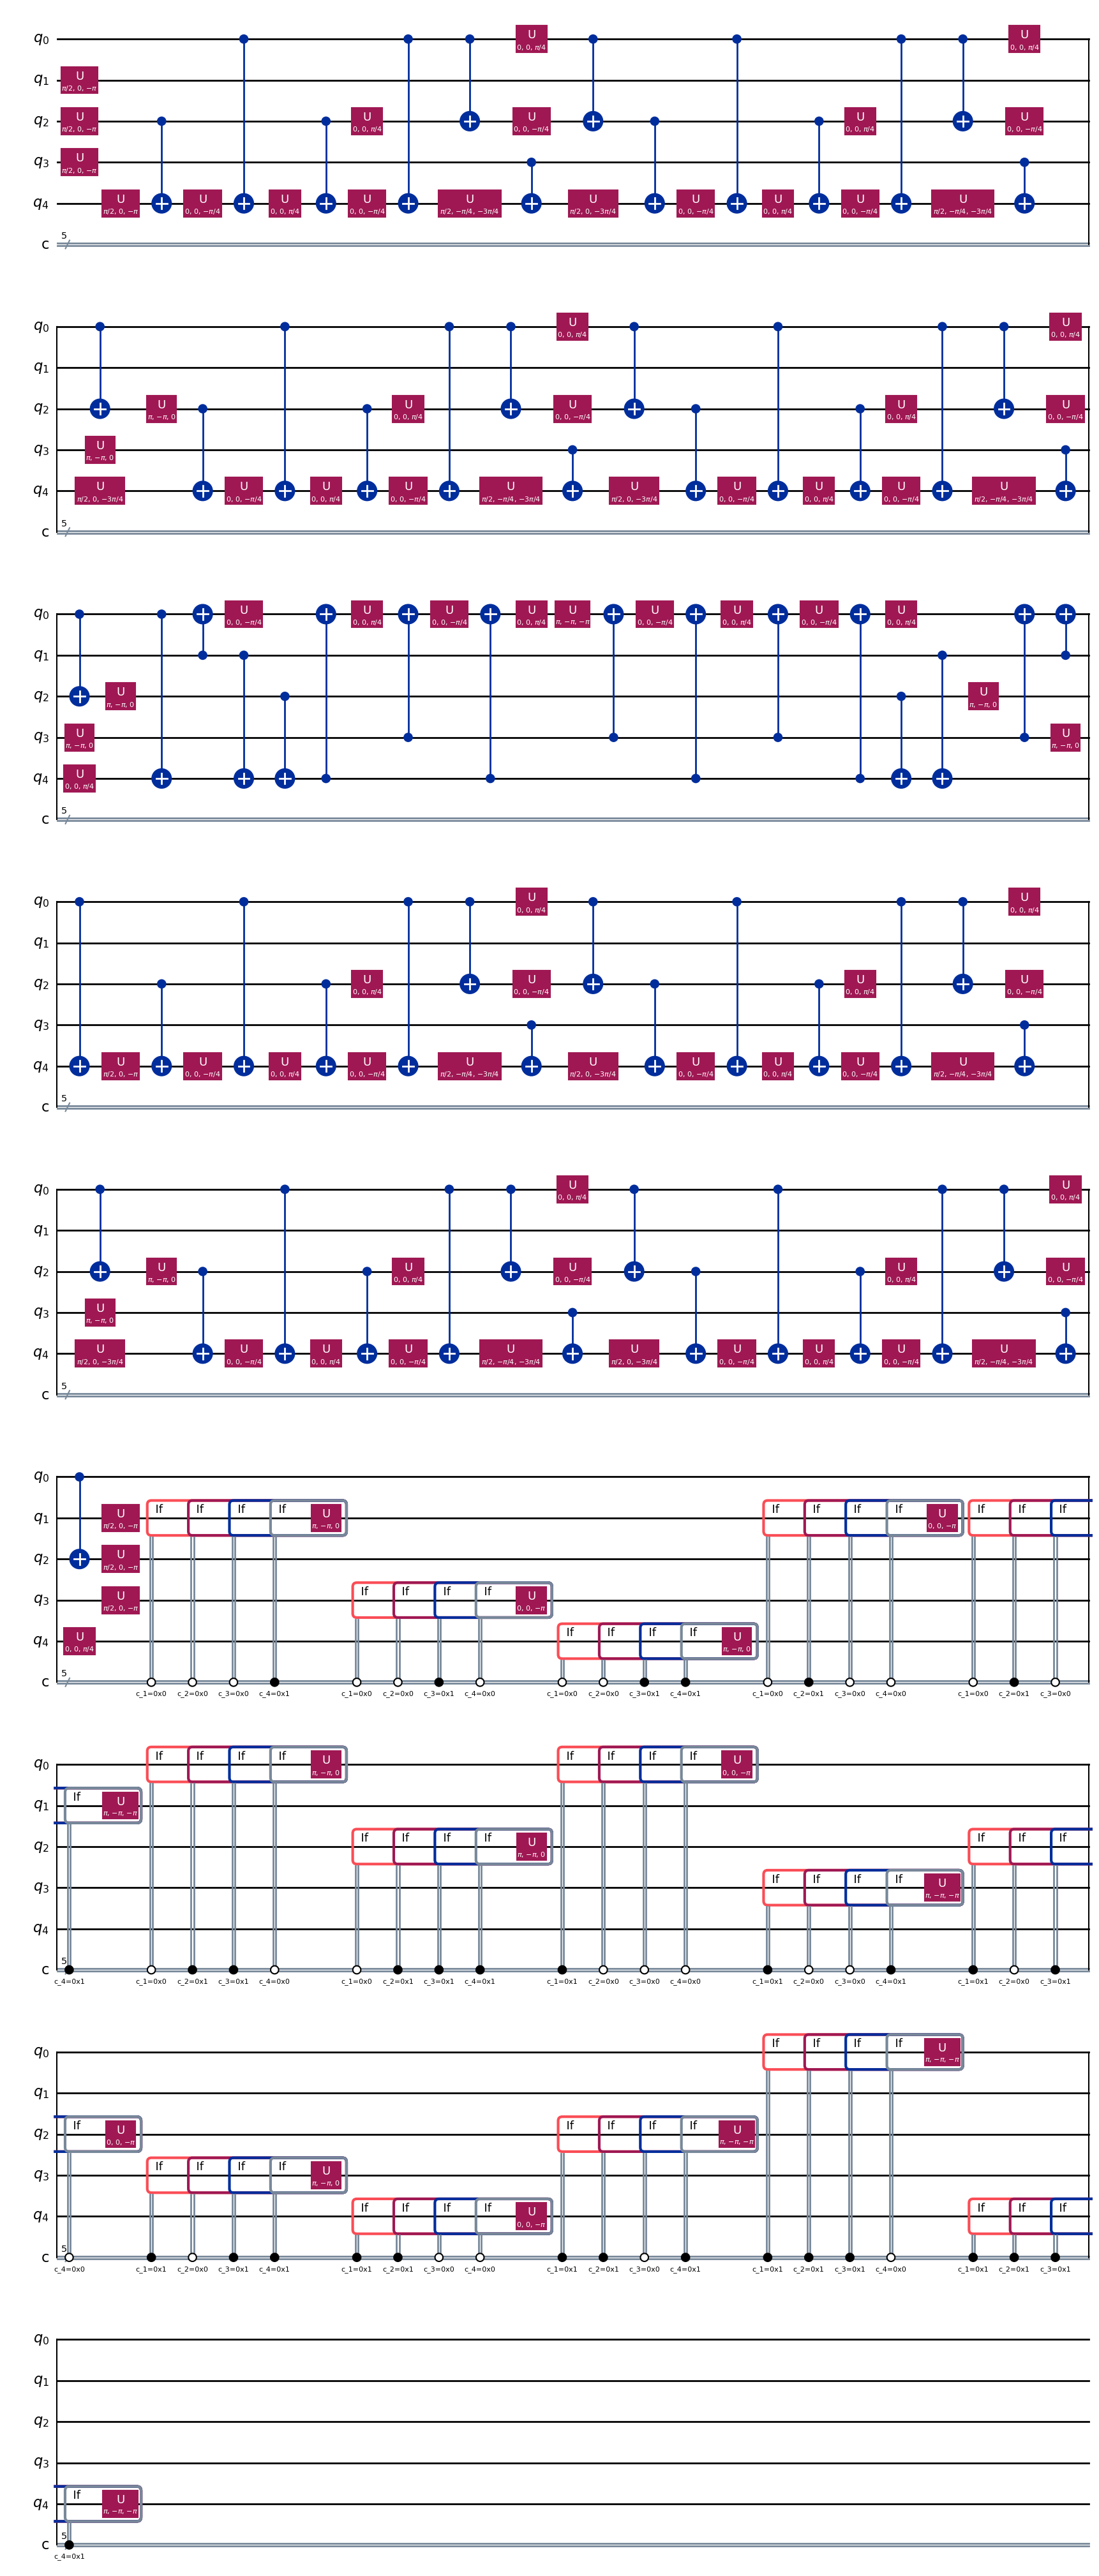

In [71]:
# Transpile the quantum circuit for the selected backend due to QFT
qct = transpile(circuits=qc, backend=backend)

# Draw circuit
qct.draw(output="mpl", style="iqp", plot_barriers=False)

Ejecutando el circuito vemos cómo los errores se han detectado y corregido correctamente.

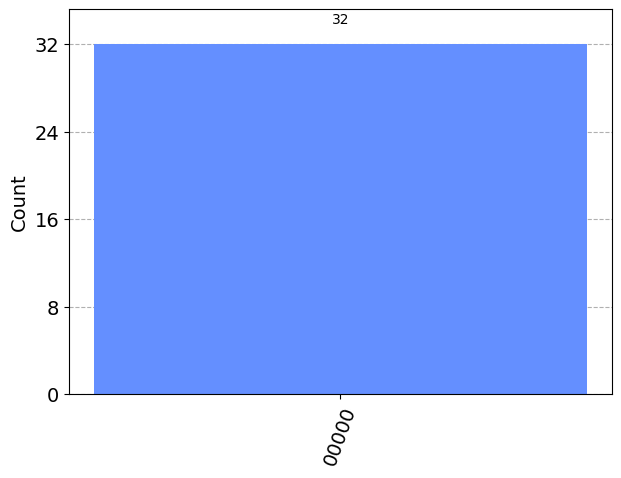

In [72]:
# Execute the quantum circuit and get the results
result = execute(qct, backend=backend, shots=32).result()
counts = result.get_counts(qct)
plot_histogram(counts)

La evolución del vector de estado es el siguiente:

In [73]:
sv_evo = statevector_evolution(result)
display_latex(sv_evo)

<IPython.core.display.Math object>

# Bibliografía

[1] Benenti, G., Casati, G., & Strini, G. (2004). Principles of Quantum Computation and Information: Volume I: Basic Concepts. Universitá degli Studi dell Insubria, Italy & Istituto Nazionale per la Fisica della Materia, Italy & Universitá di Milano, Italy. https://doi.org/10.1142/5528

[2] Marinescu, D. C. y Marinescu, G. M. (2012). Classical and Quantum Information (cap. 4, pp. 345-454). Academic Press.

[3] Knill, E., Laflamme, R., & Viola, L. (2000, March). Theory of Quantum Error Correction for General Noise. Physical Review Letters, 84(11), 2525–2528. https://doi.org/10.1103/physrevlett.84.2525

[4] Laflamme, R., Miquel, C., Paz, J. P., & Zurek, W. H. (1996). Perfect Quantum Error Correction Code. [Preprint]. arXiv:quant-ph/9602019.